# Time Series Analysis of Gold (GLD) and Silver (SLV)

This notebook provides a comprehensive analysis of the historical close price data for **Gold (GLD)** and **Silver (SLV)**. The analysis encompasses the following key steps:

1. **Data Retrieval and Preparation**
   - Fetch historical price data for GLD and SLV.
   - Clean and preprocess the data to ensure accuracy and consistency.

2. **Seasonality Handling**
   - Identify and remove seasonal patterns through seasonal differencing.
   - Perform seasonal decomposition to extract trend, seasonal, and residual components.

3. **Stationarity Testing**
   - Assess the stationarity of the time series using the Augmented Dickey-Fuller (ADF) test with both AIC and BIC for lag selection.
   - Complement the ADF test with the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test to confirm stationarity.

4. **Autocorrelation Analysis**
   - Plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) for both the trend and seasonal components of GLD and SLV.
   - Interpret these plots to understand the underlying patterns and dependencies in the data.

5. **Residuals Analysis**
   - Evaluate the residuals from the fitted models to ensure that they behave like white noise.
   - Plot residuals, their density, and their autocorrelations to diagnose model adequacy.

6. **Optimal Seasonality and Differencing**
   - Determine the optimal seasonal period for differencing and decomposition using autocorrelation analysis.
   - Identify the optimal number of differencing steps required to achieve stationarity.

Throughout the notebook, various Python libraries such as `pandas`, `numpy`, `matplotlib`, `seaborn`, and `statsmodels` are utilized to perform data manipulation, statistical testing, and visualization. Comprehensive logging is implemented to track the workflow and facilitate debugging.

**Purpose and Benefits:**
- **Data-Driven Insights:** Gain a deeper understanding of the price dynamics of Gold and Silver.
- **Model Reliability:** Ensure that the time series models are built on stationary data, enhancing forecasting accuracy.
- **Visual Diagnostics:** Use plots to intuitively assess the behavior of the time series components and residuals.
- **Automated Workflow:** Streamline the analysis process with functions that handle data retrieval, preprocessing, testing, and visualization.

By following this structured approach, the notebook aims to provide robust and insightful analysis of Gold and Silver price movements, supporting informed decision-making in financial contexts.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from polygon import StocksClient  # Ensure correct import based on Polygon API
import logging
from statsmodels.tsa.stattools import adfuller, kpss, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import find_peaks
import json

In [10]:
API_KEY = "uwQtl3txGt5BLbecq7ZbIu0ZbuitCGjc"

In [11]:

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),  # Logs to console
        logging.FileHandler("app.log")  # Logs to a file named app.log
    ]
)

# `get_GLD` Function Overview

The `get_GLD` function is an asynchronous Python function designed to retrieve, process, and analyze historical close price data for the **GLD** (SPDR Gold Shares) ticker symbol. This function leverages the `StocksClient` to fetch aggregate bar data, processes the data using `pandas`, identifies outliers, visualizes the close prices, and saves the processed data to a CSV file. Comprehensive logging is implemented to facilitate debugging and tracking of the function's execution.


2024-10-01 17:29:46,302 - INFO - Initializing StocksClient...
2024-10-01 17:29:46,404 - INFO - Fetching aggregate bars data for 'SLV'...
2024-10-01 17:29:46,664 - INFO - HTTP Request: GET https://api.polygon.io/v2/aggs/ticker/GLD/range/1/day/2019-01-01/2024-09-01?adjusted=true&sort=asc&limit=500000 "HTTP/1.1 200 OK"
2024-10-01 17:29:46,724 - INFO - Converting response to DataFrame...
2024-10-01 17:29:46,777 - INFO - Creating daily date range...
2024-10-01 17:29:46,793 - INFO - Converting 'c' column to numeric...
2024-10-01 17:29:46,796 - INFO - Mean: 168.45, Standard Deviation: 23.65
2024-10-01 17:29:46,797 - INFO - No outliers detected.
2024-10-01 17:29:46,798 - INFO - Plotting close prices...


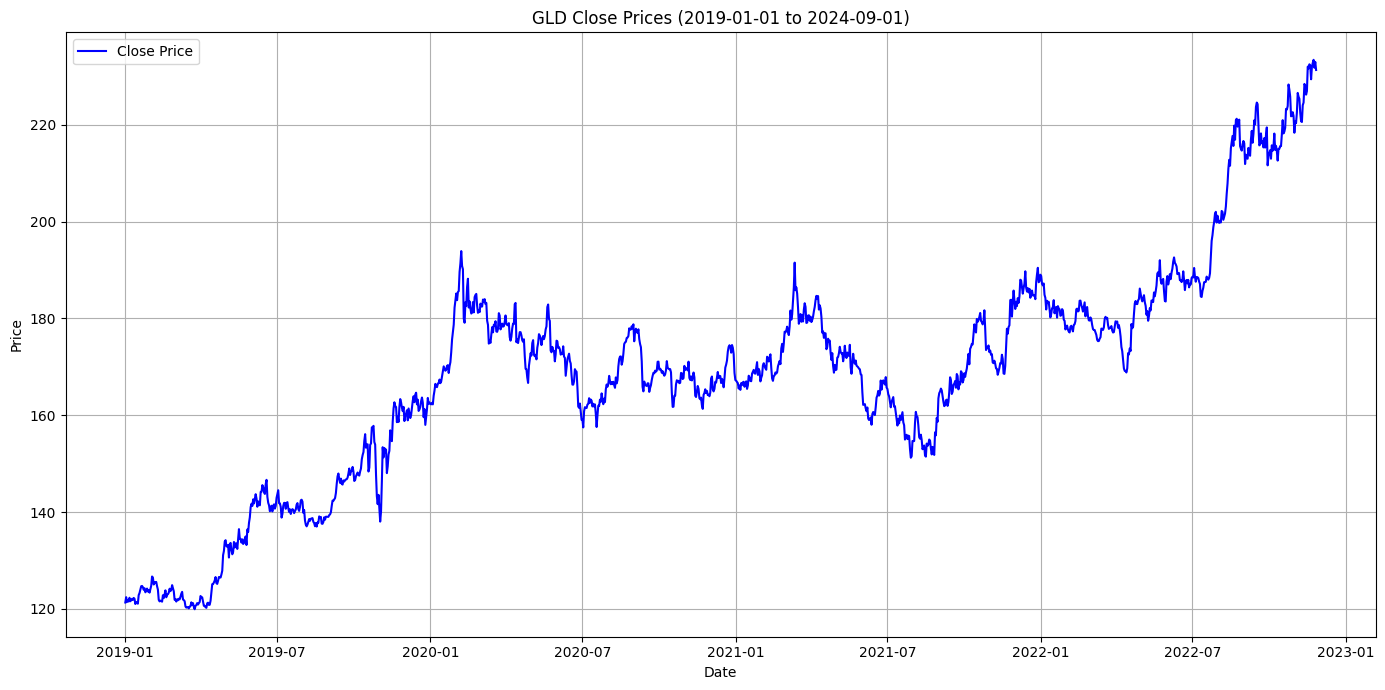

2024-10-01 17:29:47,030 - INFO - GLD prices saved to 'GLD-Prices.csv'.


,c
Date,
2019-01-01,121.33
2019-01-02,122.43
2019-01-03,121.44
2019-01-04,121.86
2019-01-05,121.53
...,...
2022-11-22,232.76
2022-11-23,233.39
2022-11-24,231.75


In [12]:
async def get_GLD(plot=False):
    try:
        logging.info("Initializing StocksClient...")
        async_stock_client = StocksClient(API_KEY, True)

        logging.info("Fetching aggregate bars data for 'SLV'...")
        response = await async_stock_client.get_aggregate_bars(
            'GLD',
            '2019-01-01',
            '2024-09-01',
            full_range=True
        )

        if not response:
            logging.error("Received empty response from StocksClient.")
            return None

        logging.info("Converting response to DataFrame...")
        df = pd.DataFrame(response)

        if 't' not in df.columns or 'c' not in df.columns:
            logging.error("Expected columns 't' or 'c' not found in response.")
            return None

        df['Date'] = pd.to_datetime(df['t'], unit='ms')
        df.set_index('Date', inplace=True)
        df.drop(columns=['t'], inplace=True)

        logging.info("Creating daily date range...")
        start_date = pd.to_datetime('2019-01-01')
        num_rows = len(df)
        df['Date'] = pd.date_range(
            start=start_date, periods=num_rows, freq='D')
        df.set_index('Date', inplace=True)

        logging.info("Converting 'c' column to numeric...")
        df['c'] = pd.to_numeric(df['c'], errors='coerce')

        mean = df['c'].mean()
        std = df['c'].std()
        logging.info(f"Mean: {mean:.2f}, Standard Deviation: {std:.2f}")

        outliers = df[(np.abs(df['c'] - mean) / std) > 3]
        if not outliers.empty:
            logging.info(f"Detected {len(outliers)} outliers.")
        else:
            logging.info("No outliers detected.")

        df = df[['c']]

        if plot:
            logging.info("Plotting close prices...")
            plt.figure(figsize=(14, 7))
            plt.plot(df.index, df['c'], label='Close Price', color='blue')
            if not outliers.empty:
                plt.scatter(outliers.index,
                            outliers['c'], color='red', label='Outliers')
            plt.title('GLD Close Prices (2019-01-01 to 2024-09-01)')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        csv_filename = 'GLD-Prices.csv'
        df.to_csv(csv_filename, index=True)
        logging.info(f"GLD prices saved to '{csv_filename}'.")

    except Exception as e:
        logging.error(f"An error occurred in get_GLD: {e}")
        return None
    return df


await get_GLD(plot=True)

# `get_SLV` Function Overview

The `get_SLV` function is an asynchronous Python function designed to retrieve, process, and analyze historical close price data for the **SLV** (iShares Silver Trust) ticker symbol. This function leverages the `StocksClient` to fetch aggregate bar data, processes the data using `pandas`, identifies outliers, visualizes the close prices, and saves the processed data to a CSV file. Comprehensive logging is implemented to facilitate debugging and tracking of the function's execution.


2024-10-01 17:29:47,045 - INFO - Initializing StocksClient...
2024-10-01 17:29:47,051 - INFO - Fetching aggregate bars data for 'SLV'...
2024-10-01 17:29:47,201 - INFO - HTTP Request: GET https://api.polygon.io/v2/aggs/ticker/SLV/range/1/day/2019-01-01/2024-09-01?adjusted=true&sort=asc&limit=500000 "HTTP/1.1 200 OK"
2024-10-01 17:29:47,323 - INFO - Converting response to DataFrame...
2024-10-01 17:29:47,346 - INFO - Creating daily date range...
2024-10-01 17:29:47,350 - INFO - Converting 'c' column to numeric...
2024-10-01 17:29:47,354 - INFO - Mean: 20.39, Standard Deviation: 3.79
2024-10-01 17:29:47,356 - INFO - No outliers detected.
2024-10-01 17:29:47,365 - INFO - Plotting close prices...


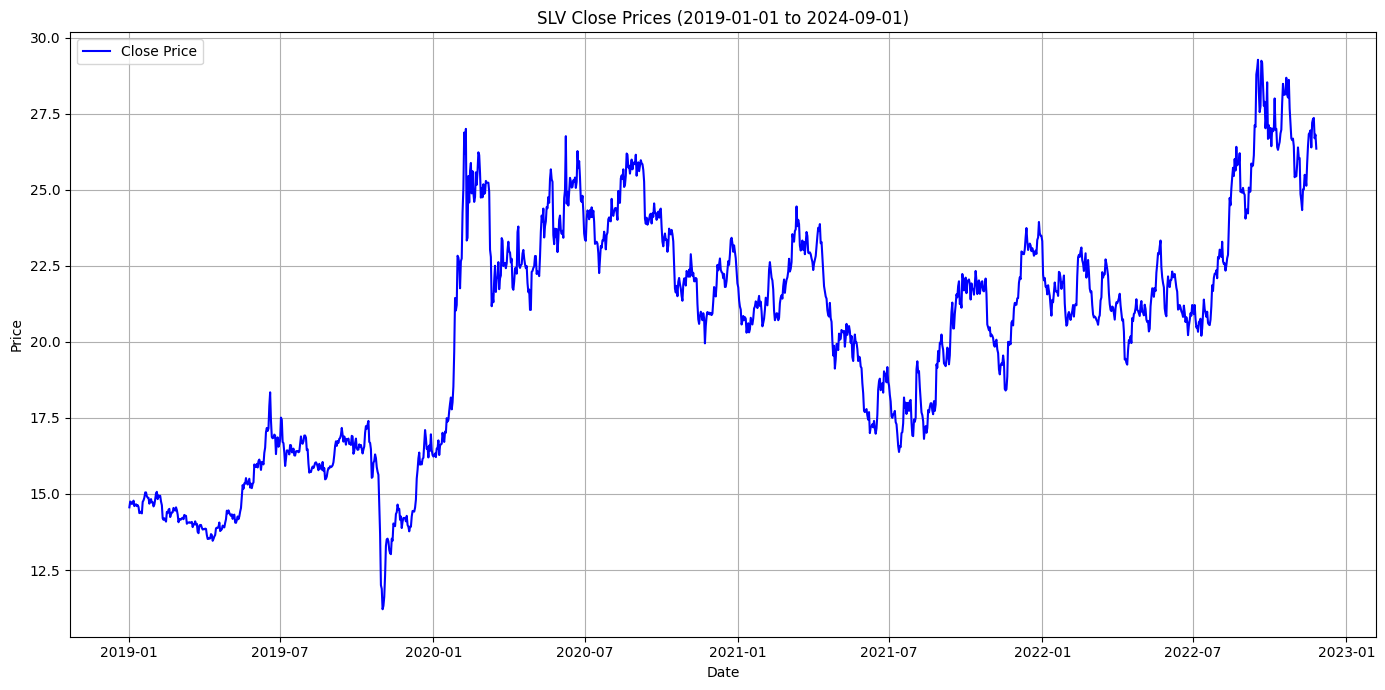

2024-10-01 17:29:47,828 - INFO - SLV prices saved to 'SLV-Prices.csv'.


,c
Date,
2019-01-01,14.56
2019-01-02,14.75
2019-01-03,14.73
2019-01-04,14.67
2019-01-05,14.69
...,...
2022-11-22,27.32
2022-11-23,27.36
2022-11-24,26.69


In [13]:
async def get_SLV(plot=False):
    try:
        logging.info("Initializing StocksClient...")
        async_stock_client = StocksClient(API_KEY, True)

        logging.info("Fetching aggregate bars data for 'SLV'...")
        response = await async_stock_client.get_aggregate_bars(
            'SLV',
            '2019-01-01',
            '2024-09-01',
            full_range=True
        )

        if not response:
            logging.error("Received empty response from StocksClient.")
            return None

        logging.info("Converting response to DataFrame...")
        df = pd.DataFrame(response)

        if 't' not in df.columns or 'c' not in df.columns:
            logging.error("Expected columns 't' or 'c' not found in response.")
            return None

        df['Date'] = pd.to_datetime(df['t'], unit='ms')
        df.set_index('Date', inplace=True)
        df.drop(columns=['t'], inplace=True)

        logging.info("Creating daily date range...")
        start_date = pd.to_datetime('2019-01-01')
        num_rows = len(df)
        df['Date'] = pd.date_range(
            start=start_date, periods=num_rows, freq='D')
        df.set_index('Date', inplace=True)

        logging.info("Converting 'c' column to numeric...")
        df['c'] = pd.to_numeric(df['c'], errors='coerce')

        mean = df['c'].mean()
        std = df['c'].std()
        logging.info(f"Mean: {mean:.2f}, Standard Deviation: {std:.2f}")

        outliers = df[(np.abs(df['c'] - mean) / std) > 3]
        if not outliers.empty:
            logging.info(f"Detected {len(outliers)} outliers.")
        else:
            logging.info("No outliers detected.")

        df = df[['c']]

        if plot:
            logging.info("Plotting close prices...")
            plt.figure(figsize=(14, 7))
            plt.plot(df.index, df['c'], label='Close Price', color='blue')
            if not outliers.empty:
                plt.scatter(outliers.index,
                            outliers['c'], color='red', label='Outliers')
            plt.title('SLV Close Prices (2019-01-01 to 2024-09-01)')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        csv_filename = 'SLV-Prices.csv'
        df.to_csv(csv_filename, index=True)
        logging.info(f"SLV prices saved to '{csv_filename}'.")

    except Exception as e:
        logging.error(f"An error occurred in get_SLV: {e}")
        return None
    return df


await get_SLV(plot=True)

# Seasonal Differencing and Decomposition Functions

## **Seasonal Differencing**

**Concept Overview:**
Seasonal differencing is a technique used in time series analysis to remove seasonal patterns from data. Seasonality refers to regular and predictable fluctuations that recur every specific period, such as daily, weekly, monthly, or yearly cycles. These patterns can obscure underlying trends and make it challenging to model and forecast the data accurately.

**Purpose:**
By applying seasonal differencing, we subtract the value of the series from its previous season (e.g., subtracting the value from 12 months ago in monthly data). This transformation helps in stabilizing the mean of the time series, making it more stationary and suitable for further analysis and modeling.

**Benefits:**
- **Enhances Stationarity:** Removes seasonal effects, leading to a more consistent mean and variance over time.
- **Improves Model Accuracy:** Facilitates the application of statistical models that assume stationarity, such as ARIMA.
- **Simplifies Forecasting:** Makes it easier to identify and model underlying trends without the interference of seasonal noise.

---

## **Seasonal Decomposition Analysis**

**Concept Overview:**
Seasonal decomposition breaks down a time series into its fundamental components: trend, seasonal, and residual (noise). This separation allows analysts to understand and interpret the different factors influencing the data.

**Purpose:**
The primary goal of seasonal decomposition is to isolate and examine each component individually. By doing so, we can gain insights into:
- **Trend:** The long-term progression or movement in the data (e.g., upward or downward trends).
- **Seasonal:** The repeating short-term cycles or patterns (e.g., increased sales during holidays).
- **Residual:** The irregular or random fluctuations that cannot be explained by trend or seasonality.

**Benefits:**
- **Enhanced Understanding:** Provides a clear view of the underlying structures within the data.
- **Improved Modeling:** Allows for more precise forecasting by modeling each component separately.
- **Anomaly Detection:** Helps in identifying outliers or unexpected changes in the residual component.

---

**In Summary:**
Both seasonal differencing and seasonal decomposition are essential tools in time series analysis for handling and understanding seasonality. Seasonal differencing focuses on removing seasonal patterns to achieve stationarity, while seasonal decomposition provides a detailed breakdown of the series into trend, seasonal, and residual components. Together, they enhance the accuracy and interpretability of time series models and forecasts.


In [14]:
def seasonal_differencing(series, seasonal_period):
    """
    Performs seasonal differencing on a time series.

    Parameters:
        series (pd.Series): The time series data.
        seasonal_period (int): The number of periods in a season (e.g., 7 for weekly seasonality).

    Returns:
        pd.Series: Seasonally differenced series.
    """
    try:
        logging.info(
            f"Performing seasonal differencing with period={seasonal_period}...")
        differenced = series.diff(seasonal_period).dropna()
        logging.info("Seasonal differencing completed.")
        return differenced
    except Exception as e:
        logging.error(f"An error occurred during seasonal differencing: {e}")
        return None
    

def seasonal_decomposition_analysis(series, seasonal_period, model='additive'):
    """
    Performs seasonal decomposition on a time series.

    Parameters:
        series (pd.Series): The time series data.
        seasonal_period (int): The number of periods in a season.
        model (str): Type of seasonal component ('additive' or 'multiplicative').

    Returns:
        DecomposeResult: Object containing the trend, seasonal, and residual components.
    """
    try:
        logging.info(
            f"Performing seasonal decomposition with period={seasonal_period} and model='{model}'...")
        decomposition = seasonal_decompose(
            series, model=model, period=seasonal_period, extrapolate_trend='freq')
        logging.info("Seasonal decomposition completed.")
        return decomposition
    except Exception as e:
        logging.error(f"An error occurred during seasonal decomposition: {e}")
        return None

# Augmented Dickey-Fuller (ADF) and KPSS Test Functions

## **`perform_adf_test` Function

**Purpose:**  
The `perform_adf_test` function conducts the Augmented Dickey-Fuller (ADF) test on a time series to determine its stationarity. Stationarity is a crucial property for many time series models, indicating that the statistical properties of the series remain constant over time.

**Concept Overview:**
- **Augmented Dickey-Fuller (ADF) Test:**  
  A statistical test used to assess whether a time series has a unit root, which implies non-stationarity. The ADF test helps in identifying the presence of a trend or other forms of non-stationarity in the data.

**Workflow:**
1. **Seasonal Differencing:**  
   The function first removes seasonal patterns from the data by applying seasonal differencing. This step stabilizes the mean of the series by eliminating regular seasonal fluctuations.
   
2. **Visualization:**  
   After differencing, the function plots the transformed series. Visual inspection of this plot aids in assessing the stationarity of the series.
   
3. **ADF Testing:**  
   The ADF test is then performed on the seasonally differenced series. The results, including the test statistic and p-value, indicate whether the series is stationary.

**Key Outcomes:**
- **Test Statistic & p-value:**  
  These values help in determining whether to reject the null hypothesis of non-stationarity.
  
- **Decision Making:**  
  A low p-value suggests rejecting the null hypothesis, indicating that the series is stationary.

---

## **`perform_kpss_test` Function

**Purpose:**  
The `perform_kpss_test` function executes the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test on a time series to evaluate its stationarity. Unlike the ADF test, the KPSS test has a different null hypothesis, providing complementary insights into the stationarity of the data.

**Concept Overview:**
- **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:**  
  A statistical test used to examine whether a time series is stationary around a deterministic trend (trend-stationary) or has a unit root (non-stationary). The KPSS test assesses the null hypothesis that an observable time series is stationary.

**Workflow:**
1. **Seasonal Differencing:**  
   Similar to the ADF test function, KPSS begins by removing seasonal effects through seasonal differencing, ensuring that the test focuses on the underlying trend and residual components.
   
2. **Visualization:**  
   The seasonally differenced series is plotted to provide a visual assessment of its stationarity, aiding in the interpretation of the test results.
   
3. **KPSS Testing:**  
   The KPSS test is performed on the transformed series. The results, including the test statistic and p-value, help determine the stationarity of the series.

**Key Outcomes:**
- **Test Statistic & p-value:**  
  These metrics are used to decide whether to reject the null hypothesis of stationarity.
  
- **Decision Making:**  
  A low p-value indicates rejecting the null hypothesis, suggesting that the series is non-stationary.

---

## **Summary**

Both `perform_adf_test` and `perform_kpss_test` functions are integral for assessing the stationarity of time series data, a fundamental assumption for many forecasting models. By incorporating seasonal differencing and visualizations, these functions provide a comprehensive analysis:

- **`perform_adf_test`:**  
  Focuses on identifying unit roots to determine stationarity, with the null hypothesis being non-stationarity.

- **`perform_kpss_test`:**  
  Evaluates stationarity with the null hypothesis being stationarity, offering a complementary perspective to the ADF test.

Together, these functions enable robust diagnostics of time series data, ensuring that subsequent modeling efforts are based on sound statistical foundations.


In [15]:
async def perform_adf_test(ticker, series, seasonal_period=7):
    """
    Performs the Augmented Dickey-Fuller test on a seasonally differenced series using both AIC and BIC for lag selection.

    Parameters:
        ticker (str): The ticker symbol (e.g., 'GLD').
        series (pd.Series): The original time series data.
        seasonal_period (int): The number of periods in a season.

    Returns:
        dict: A dictionary containing the test results for both AIC and BIC.
    """
    try:
        logging.info("Starting ADF test with seasonal differencing...")

        # Perform seasonal differencing
        differenced = seasonal_differencing(series, seasonal_period)
        if differenced is None or differenced.empty:
            logging.error(
                "Seasonal differencing failed or resulted in empty series.")
            return None

        # Plot the seasonally differenced data
        logging.info("Plotting seasonally differenced data for ADF test...")
        plt.figure(figsize=(14, 7))
        plt.plot(differenced.index, differenced,
                 label='Seasonally Differenced Close Price', color='green')
        plt.title(
            f'Seasonally Differenced {ticker} Close Prices (Period={seasonal_period})')
        plt.xlabel('Date')
        plt.ylabel('Differenced Price')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Drop NaN values
        differenced = differenced.dropna()
        if differenced.empty:
            logging.error(
                "No data available after seasonal differencing for ADF test.")
            return None

        # Define the information criteria to use
        info_criteria = ['AIC', 'BIC']
        adf_results = {}

        for criterion in info_criteria:
            logging.info(
                f"Performing ADF test using {criterion} for lag selection...")
            adf_test = adfuller(differenced, autolag=criterion)

            adf_output = {
                'Test Statistic': adf_test[0],
                'p-value': adf_test[1],
                'Used Lag': adf_test[2],
                'Number of Observations': adf_test[3],
                'Critical Values': adf_test[4],
                'IC Best': adf_test[5]
            }

            adf_results[f'ADF Test ({criterion})'] = adf_output

            logging.info(f"ADF Test Results using {criterion}:")
            for key, value in adf_output.items():
                if key != 'Critical Values':
                    logging.info(f"{key}: {value}")
                else:
                    logging.info("Critical Values:")
                    for cv_key, cv_value in value.items():
                        logging.info(f"   {cv_key}: {cv_value}")

        return adf_results

    except Exception as e:
        logging.error(f"An error occurred during ADF test: {e}")
        return None



async def perform_kpss_test(ticker, series, seasonal_period=7, regression='c'):
    """
    Performs the KPSS test on a seasonally differenced series.

    Parameters:
        series (pd.Series): The original time series data.
        seasonal_period (int): The number of periods in a season.
        regression (str): Type of regression to include in the test ('c' or 'ct').

    Returns:
        dict: A dictionary containing the test results.
    """
    try:
        logging.info("Starting KPSS test with seasonal differencing...")

        # Perform seasonal differencing
        differenced = seasonal_differencing(series, seasonal_period)
        if differenced is None or differenced.empty:
            logging.error(
                "Seasonal differencing failed or resulted in empty series.")
            return None

        # Plot the seasonally differenced data
        logging.info("Plotting seasonally differenced data for KPSS test...")
        plt.figure(figsize=(14, 7))
        plt.plot(differenced.index, differenced,
                 label='Seasonally Differenced Close Price', color='purple')
        plt.title(
            f'Seasonally Differenced {ticker} Close Prices (Period={seasonal_period})')
        plt.xlabel('Date')
        plt.ylabel('Differenced Price')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Drop NaN values
        differenced = differenced.dropna()
        if differenced.empty:
            logging.error(
                "No data available after seasonal differencing for KPSS test.")
            return None

        # Perform KPSS test
        kpss_result = kpss(differenced, regression=regression, nlags="auto")

        kpss_output = {
            'Test Statistic': kpss_result[0],
            'p-value': kpss_result[1],
            'Lags Used': kpss_result[2],
            'Critical Values': kpss_result[3]
        }

        logging.info("KPSS Test Results (on seasonally differenced data):")
        for key, value in kpss_output.items():
            if key != 'Critical Values':
                logging.info(f"{key}: {value}")
            else:
                logging.info("Critical Values:")
                for cv_key, cv_value in value.items():
                    logging.info(f"   {cv_key}: {cv_value}")

        return kpss_output

    except Exception as e:
        logging.error(f"An error occurred during KPSS test: {e}")
        return None

# GLD Data Retrieval and Stationarity Testing

This workflow outlines the steps to fetch historical **GLD** (SPDR Gold Shares) close price data, assess its stationarity, and save the analysis results for future reference.

## **Workflow Steps**

1. **Data Retrieval**
   - **Fetch GLD Data:**  
     Retrieve historical close price data for the GLD ticker from January 1, 2019, to September 1, 2024.
   - **Validation:**  
     Ensure that the data retrieval was successful. If not, log an error and halt the process.

2. **Stationarity Testing**
   - **Augmented Dickey-Fuller (ADF) Test:**  
     Assess whether the GLD time series is stationary. A stationary series has constant statistical properties over time, which is essential for reliable forecasting.
   - **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:**  
     Complement the ADF test by evaluating the stationarity of the series from a different perspective. While ADF tests for non-stationarity, KPSS tests for stationarity.

3. **Results Compilation**
   - **Aggregate Test Results:**  
     Combine the outcomes of both the ADF and KPSS tests into a single dictionary for easy interpretation.

4. **Logging and Saving**
   - **Log Test Results:**  
     Record the test results in the logging system to keep a record of the analysis.
   - **Save to JSON:**  
     Export the compiled test results to a JSON file (`GLD_Test_Results.json`) for persistent storage and future analysis.

## **Purpose and Benefits**

- **Data Integrity:**  
  Ensures that only valid and successfully retrieved data is processed, preventing errors in subsequent analysis.
  
- **Comprehensive Analysis:**  
  Utilizing both ADF and KPSS tests provides a robust assessment of the time series' stationarity, leveraging the strengths of each test.
  
- **Record Keeping:**  
  Saving results to a JSON file allows for easy access, sharing, and integration with other tools or reports.

## **Conclusion**

By following this workflow, you can effectively retrieve GLD close price data, evaluate its stationarity, and maintain a clear record of your analysis. This process is fundamental for time series forecasting and financial analysis, ensuring that models are built on stable and reliable data foundations.


2024-10-01 17:29:47,870 - INFO - Initializing StocksClient...
2024-10-01 17:29:47,890 - INFO - Fetching aggregate bars data for 'SLV'...
2024-10-01 17:29:48,064 - INFO - HTTP Request: GET https://api.polygon.io/v2/aggs/ticker/GLD/range/1/day/2019-01-01/2024-09-01?adjusted=true&sort=asc&limit=500000 "HTTP/1.1 200 OK"
2024-10-01 17:29:48,130 - INFO - Converting response to DataFrame...
2024-10-01 17:29:48,133 - INFO - Creating daily date range...
2024-10-01 17:29:48,134 - INFO - Converting 'c' column to numeric...
2024-10-01 17:29:48,135 - INFO - Mean: 168.45, Standard Deviation: 23.65
2024-10-01 17:29:48,136 - INFO - No outliers detected.
2024-10-01 17:29:48,139 - INFO - GLD prices saved to 'GLD-Prices.csv'.
2024-10-01 17:29:48,140 - INFO - Starting ADF test with seasonal differencing...
2024-10-01 17:29:48,140 - INFO - Performing seasonal differencing with period=7...
2024-10-01 17:29:48,142 - INFO - Seasonal differencing completed.
2024-10-01 17:29:48,142 - INFO - Plotting seasonally 

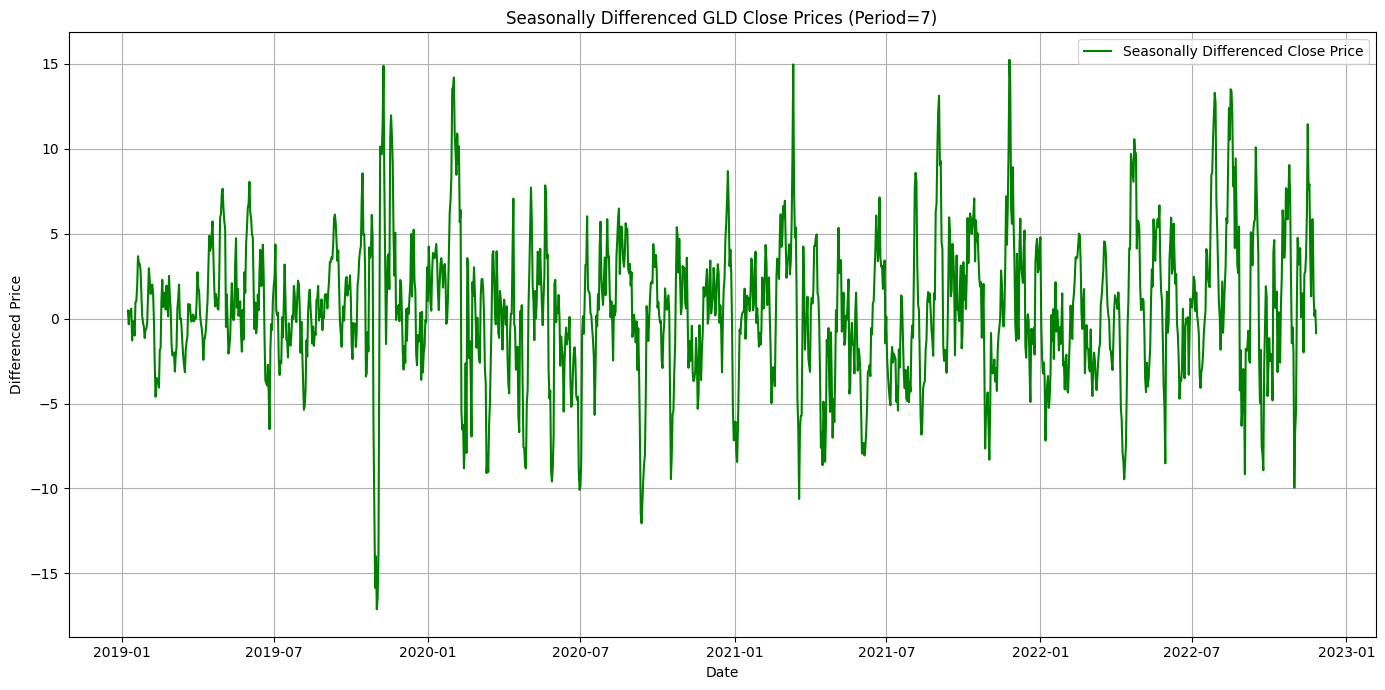

2024-10-01 17:29:48,314 - INFO - Performing ADF test using AIC for lag selection...
2024-10-01 17:29:48,349 - INFO - ADF Test Results using AIC:
2024-10-01 17:29:48,349 - INFO - Test Statistic: -6.5842170652828775
2024-10-01 17:29:48,349 - INFO - p-value: 7.383913067736119e-09
2024-10-01 17:29:48,350 - INFO - Used Lag: 21
2024-10-01 17:29:48,350 - INFO - Number of Observations: 1397
2024-10-01 17:29:48,350 - INFO - Critical Values:
2024-10-01 17:29:48,351 - INFO -    1%: -3.4350395894411734
2024-10-01 17:29:48,351 - INFO -    5%: -2.863611117606763
2024-10-01 17:29:48,352 - INFO -    10%: -2.5678726562185354
2024-10-01 17:29:48,352 - INFO - IC Best: 5547.328124708149
2024-10-01 17:29:48,352 - INFO - Performing ADF test using BIC for lag selection...
2024-10-01 17:29:48,375 - INFO - ADF Test Results using BIC:
2024-10-01 17:29:48,376 - INFO - Test Statistic: -6.5842170652828775
2024-10-01 17:29:48,376 - INFO - p-value: 7.383913067736119e-09
2024-10-01 17:29:48,376 - INFO - Used Lag: 21


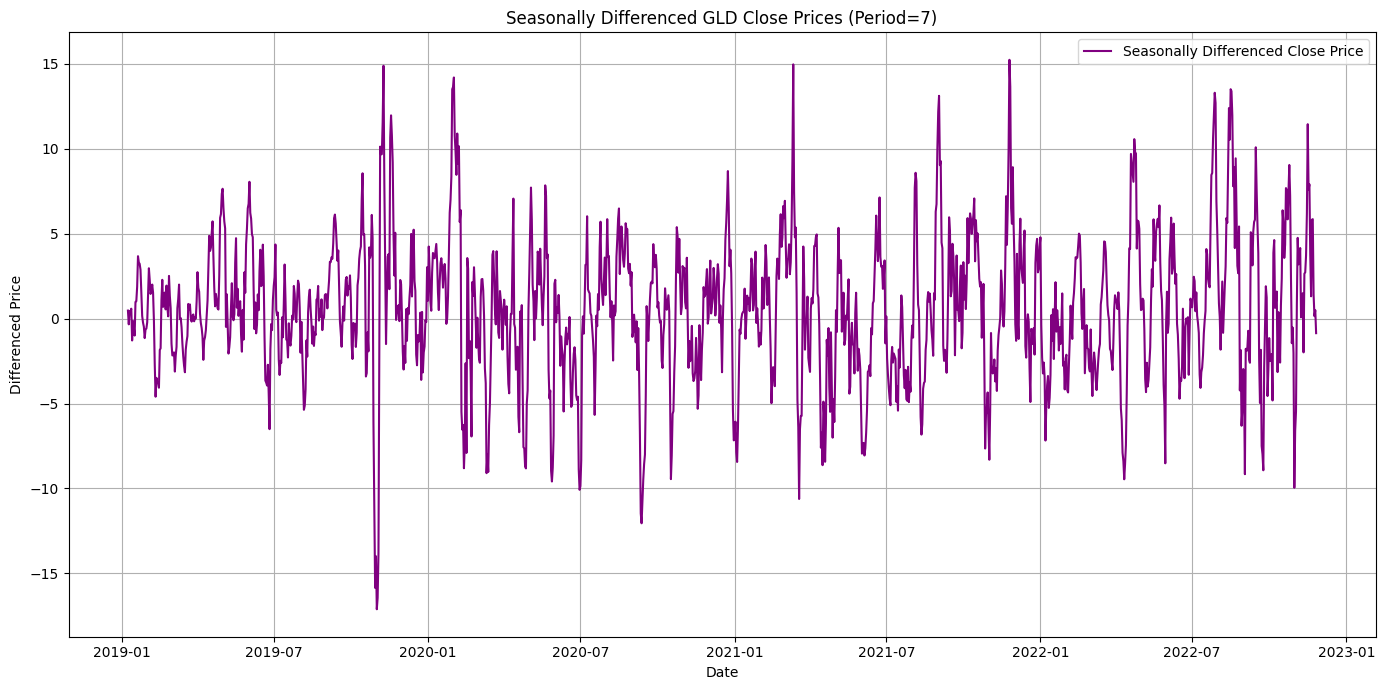

2024-10-01 17:29:48,543 - INFO - KPSS Test Results (on seasonally differenced data):
2024-10-01 17:29:48,544 - INFO - Test Statistic: 0.12730774138594153
2024-10-01 17:29:48,544 - INFO - p-value: 0.0846152937297379
2024-10-01 17:29:48,544 - INFO - Lags Used: 20
2024-10-01 17:29:48,545 - INFO - Critical Values:
2024-10-01 17:29:48,545 - INFO -    10%: 0.119
2024-10-01 17:29:48,545 - INFO -    5%: 0.146
2024-10-01 17:29:48,545 - INFO -    2.5%: 0.176
2024-10-01 17:29:48,546 - INFO -    1%: 0.216
2024-10-01 17:29:48,546 - INFO - Test Results:
2024-10-01 17:29:48,546 - INFO - {
    "ADF Test": {
        "ADF Test (AIC)": {
            "Test Statistic": -6.5842170652828775,
            "p-value": 7.383913067736119e-09,
            "Used Lag": 21,
            "Number of Observations": 1397,
            "Critical Values": {
                "1%": -3.4350395894411734,
                "5%": -2.863611117606763,
                "10%": -2.5678726562185354
            },
            "IC Best": 5547.

In [16]:
# Fetch the GLD data
data = await get_GLD()

if data is None:
    logging.error("Data fetching failed. Exiting main function.")


# Perform ADF Test
adf_results = await perform_adf_test('GLD', data)
if adf_results is None:
    logging.error("ADF test failed.")

# Perform KPSS Test
# Use 'ct' if you want to include a trend
kpss_results = await perform_kpss_test('GLD', data, regression='ct')
if kpss_results is None:
    logging.error("KPSS test failed.")

# Prepare the test results dictionary
test_results = {
    'ADF Test': adf_results,
    'KPSS Test': kpss_results
}

# Log the test results
logging.info("Test Results:")
logging.info(json.dumps(test_results, indent=4))

# Save the test results to a JSON file
json_filename = 'GLD_Test_Results.json'
try:
    with open(json_filename, 'w') as json_file:
        json.dump(test_results, json_file, indent=4, default=str)
    logging.info(f"Test results saved to '{json_filename}'.")
except Exception as e:
    logging.error(f"Failed to save test results to JSON: {e}")

# Stationarity Analysis for Gold (GLD)

This section presents the results of the **Augmented Dickey-Fuller (ADF) Test** and the **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test** conducted on the Gold (GLD) time series data. These tests assess the stationarity of the series, which is a fundamental assumption for many time series forecasting models.

---

### **1. Augmented Dickey-Fuller (ADF) Test**

The ADF test evaluates the null hypothesis $H_0$ that the time series has a unit root, implying it is non-stationary. Rejecting $H_0$ suggests that the series is stationary.

- **ADF Test (AIC):**
  - **Test Statistic:** -6.5842
  - **p-value:** 7.38e-09
  - **Used Lag:** 21
  - **Number of Observations:** 1397
  - **Critical Values:**
    - 1%: -3.4350
    - 5%: -2.8636
    - 10%: -2.5679
  - **IC Best (AIC):** 5547.33

- **ADF Test (BIC):**
  - **Test Statistic:** -6.5842
  - **p-value:** 7.38e-09
  - **Used Lag:** 21
  - **Number of Observations:** 1397
  - **Critical Values:**
    - 1%: -3.4350
    - 5%: -2.8636
    - 10%: -2.5679
  - **IC Best (BIC):** 5667.85

**Interpretation:**
- Both AIC and BIC criteria yield highly significant p-values (~7.38e-09), which are much lower than the standard significance level of 0.05.
- **Conclusion:** We reject the null hypothesis $H_0$ of non-stationarity. Therefore, the GLD series is **stationary** based on the ADF test.

---

### **2. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test**

The KPSS test evaluates the null hypothesis $H_0$ that the time series is stationary around a deterministic trend. Unlike the ADF test, a low p-value here indicates non-stationarity.

- **Test Statistic:** 0.1273
- **p-value:** 0.0846
- **Lags Used:** 20
- **Critical Values:**
  - 10%: 0.119
  - 5%: 0.146
  - 2.5%: 0.176
  - 1%: 0.216

**Interpretation:**
- The p-value is 0.0846, which is greater than the significance level of 0.05.
- **Conclusion:** We fail to reject the null hypothesis $H_0$ of stationarity. Thus, the KPSS test also indicates that the GLD series is **stationary**.

---

### **Overall Conclusion for Gold (GLD)**

Both the **ADF** and **KPSS** tests consistently confirm that the Gold (GLD) time series is **stationary** after seasonal differencing. This stationarity is essential for building reliable time series models, ensuring that the statistical properties of the series remain constant over time.

---

### **Recommendations**

1. **Model Selection:**  
   Proceed with fitting appropriate time series models (e.g., ARIMA, SARIMA) to the stationary GLD data for forecasting purposes.

2. **Residual Analysis:**  
   After modeling, perform residual diagnostics to ensure that residuals behave like white noise, indicating a good fit.

3. **Continuous Monitoring:**  
   Regularly reassess stationarity, especially if new data is added, to maintain model accuracy.

---


# SLV Data Retrieval and Stationarity Testing

This workflow outlines the steps to fetch historical **SLV** (iShares Silver Trust) close price data, assess its stationarity, and save the analysis results for future reference.

## **Workflow Steps**

1. **Data Retrieval**
   - **Fetch SLV Data:**  
     Retrieve historical close price data for the SLV ticker from January 1, 2019, to September 1, 2024.
   - **Validation:**  
     Ensure that the data retrieval was successful. If not, log an error and halt the process.

2. **Stationarity Testing**
   - **Augmented Dickey-Fuller (ADF) Test:**  
     Assess whether the SLV time series is stationary. A stationary series has constant statistical properties over time, which is essential for reliable forecasting.
   - **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:**  
     Complement the ADF test by evaluating the stationarity of the series from a different perspective. While ADF tests for non-stationarity, KPSS tests for stationarity.

3. **Results Compilation**
   - **Aggregate Test Results:**  
     Combine the outcomes of both the ADF and KPSS tests into a single dictionary for easy interpretation.

4. **Logging and Saving**
   - **Log Test Results:**  
     Record the test results in the logging system to keep a record of the analysis.
   - **Save to JSON:**  
     Export the compiled test results to a JSON file (`SLV_Test_Results.json`) for persistent storage and future analysis.

## **Purpose and Benefits**

- **Data Integrity:**  
  Ensures that only valid and successfully retrieved data is processed, preventing errors in subsequent analysis.
  
- **Comprehensive Analysis:**  
  Utilizing both ADF and KPSS tests provides a robust assessment of the time series' stationarity, leveraging the strengths of each test.
  
- **Record Keeping:**  
  Saving results to a JSON file allows for easy access, sharing, and integration with other tools or reports.

## **Conclusion**

By following this workflow, you can effectively retrieve SLV close price data, evaluate its stationarity, and maintain a clear record of your analysis. This process is fundamental for time series forecasting and financial analysis, ensuring that models are built on stable and reliable data foundations.


2024-10-01 17:29:48,558 - INFO - Initializing StocksClient...
2024-10-01 17:29:48,568 - INFO - Fetching aggregate bars data for 'SLV'...
2024-10-01 17:29:48,737 - INFO - HTTP Request: GET https://api.polygon.io/v2/aggs/ticker/SLV/range/1/day/2019-01-01/2024-09-01?adjusted=true&sort=asc&limit=500000 "HTTP/1.1 200 OK"
2024-10-01 17:29:48,777 - INFO - Converting response to DataFrame...
2024-10-01 17:29:48,780 - INFO - Creating daily date range...
2024-10-01 17:29:48,781 - INFO - Converting 'c' column to numeric...
2024-10-01 17:29:48,782 - INFO - Mean: 20.39, Standard Deviation: 3.79
2024-10-01 17:29:48,783 - INFO - No outliers detected.
2024-10-01 17:29:48,787 - INFO - SLV prices saved to 'SLV-Prices.csv'.
2024-10-01 17:29:48,787 - INFO - Starting ADF test with seasonal differencing...
2024-10-01 17:29:48,788 - INFO - Performing seasonal differencing with period=7...
2024-10-01 17:29:48,789 - INFO - Seasonal differencing completed.
2024-10-01 17:29:48,789 - INFO - Plotting seasonally di

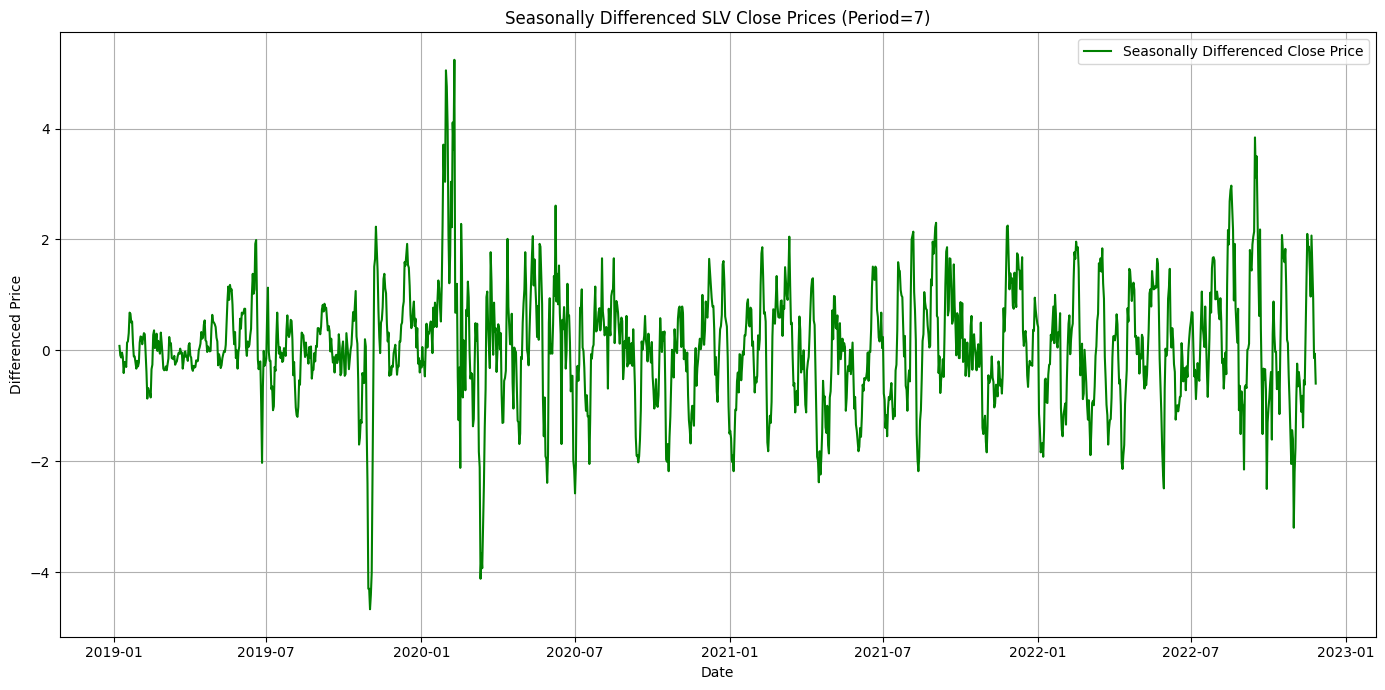

2024-10-01 17:29:48,944 - INFO - Performing ADF test using AIC for lag selection...
2024-10-01 17:29:48,964 - INFO - ADF Test Results using AIC:
2024-10-01 17:29:48,965 - INFO - Test Statistic: -6.493721214249773
2024-10-01 17:29:48,965 - INFO - p-value: 1.208776016140803e-08
2024-10-01 17:29:48,965 - INFO - Used Lag: 23
2024-10-01 17:29:48,966 - INFO - Number of Observations: 1395
2024-10-01 17:29:48,966 - INFO - Critical Values:
2024-10-01 17:29:48,966 - INFO -    1%: -3.435046325299633
2024-10-01 17:29:48,966 - INFO -    5%: -2.8636140901080456
2024-10-01 17:29:48,966 - INFO -    10%: -2.567874239154173
2024-10-01 17:29:48,967 - INFO - IC Best: 1710.9142285911075
2024-10-01 17:29:48,967 - INFO - Performing ADF test using BIC for lag selection...
2024-10-01 17:29:48,988 - INFO - ADF Test Results using BIC:
2024-10-01 17:29:48,988 - INFO - Test Statistic: -6.494127552420273
2024-10-01 17:29:48,989 - INFO - p-value: 1.2061130813480711e-08
2024-10-01 17:29:48,989 - INFO - Used Lag: 21
2

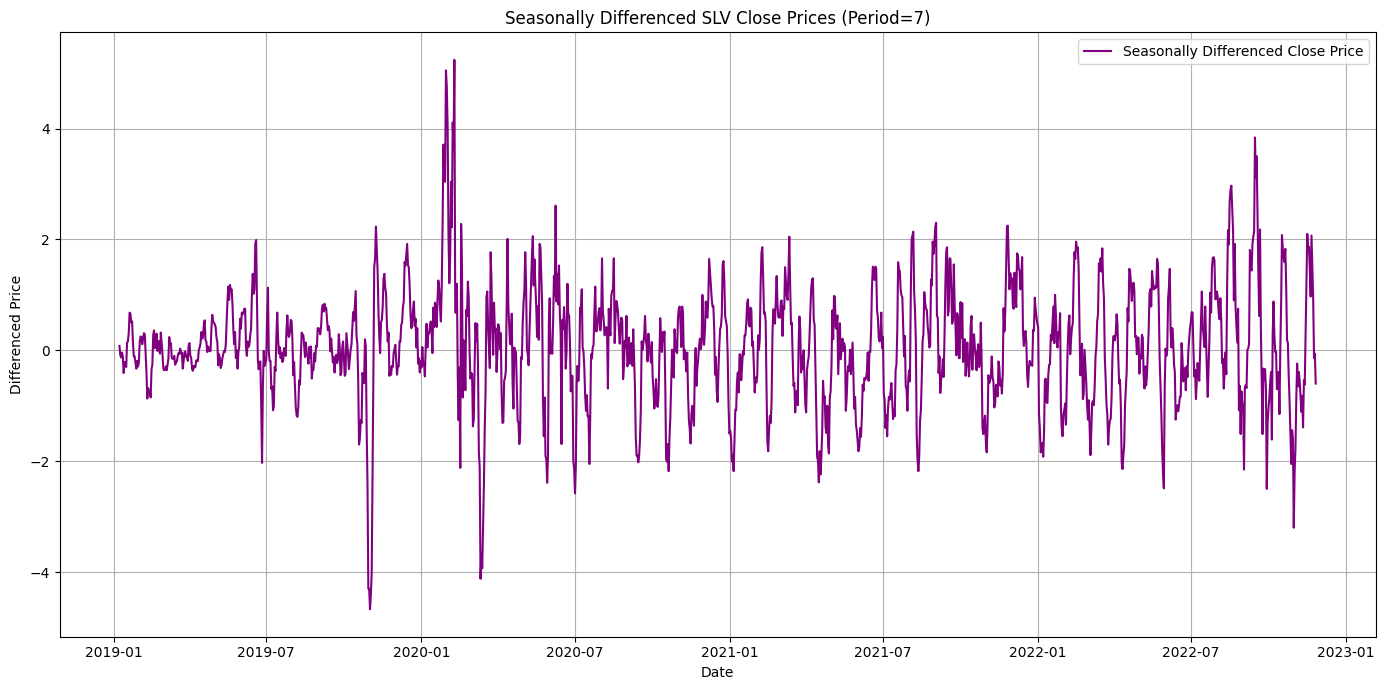

/var/folders/2c/trmbhl295p74b6v9kd24x24h0000gn/T/ipykernel_90669/3844592815.py:125: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(differenced, regression=regression, nlags="auto")
2024-10-01 17:29:49,136 - INFO - KPSS Test Results (on seasonally differenced data):
2024-10-01 17:29:49,137 - INFO - Test Statistic: 0.05451079002927221
2024-10-01 17:29:49,137 - INFO - p-value: 0.1
2024-10-01 17:29:49,138 - INFO - Lags Used: 20
2024-10-01 17:29:49,138 - INFO - Critical Values:
2024-10-01 17:29:49,138 - INFO -    10%: 0.347
2024-10-01 17:29:49,138 - INFO -    5%: 0.463
2024-10-01 17:29:49,138 - INFO -    2.5%: 0.574
2024-10-01 17:29:49,139 - INFO -    1%: 0.739
2024-10-01 17:29:49,139 - INFO - Test Results:
2024-10-01 17:29:49,139 - INFO - {
    "ADF Test": {
        "ADF Test (AIC)": {
            "Test Statistic": -6.493721214249773,
            "p-v

In [17]:
# Fetch the SLV data
data = await get_SLV()

if data is None:
    logging.error("Data fetching failed. Exiting main function.")
    

# Perform ADF Test
adf_results = await perform_adf_test('SLV', data)
if adf_results is None:
    logging.error("ADF test failed.")

# Perform KPSS Test
kpss_results = await perform_kpss_test('SLV', data, regression='c')  # Use 'ct' if you want to include a trend
if kpss_results is None:
    logging.error("KPSS test failed.")

# Prepare the test results dictionary
test_results = {
    'ADF Test': adf_results,
    'KPSS Test': kpss_results
}

# Log the test results
logging.info("Test Results:")
logging.info(json.dumps(test_results, indent=4))

# Save the test results to a JSON file
json_filename = 'SLV_Test_Results.json'
try:
    with open(json_filename, 'w') as json_file:
        json.dump(test_results, json_file, indent=4, default=str)
    logging.info(f"Test results saved to '{json_filename}'.")
except Exception as e:
    logging.error(f"Failed to save test results to JSON: {e}")

# Stationarity Analysis for Silver (SLV)

This section presents the results of the **Augmented Dickey-Fuller (ADF) Test** and the **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test** conducted on the Silver (SLV) time series data. These tests evaluate the stationarity of the series, a crucial aspect for effective time series forecasting.

---

### **1. Augmented Dickey-Fuller (ADF) Test**

The ADF test assesses the null hypothesis $H_0$ that the time series possesses a unit root, indicating non-stationarity. Rejecting $H_0$ suggests that the series is stationary.

- **ADF Test (AIC):**
  - **Test Statistic:** -6.4937
  - **p-value:** 1.21e-08
  - **Used Lag:** 23
  - **Number of Observations:** 1395
  - **Critical Values:**
    - 1%: -3.4350
    - 5%: -2.8636
    - 10%: -2.5679
  - **IC Best (AIC):** 1710.91

- **ADF Test (BIC):**
  - **Test Statistic:** -6.4941
  - **p-value:** 1.21e-08
  - **Used Lag:** 21
  - **Number of Observations:** 1397
  - **Critical Values:**
    - 1%: -3.4350
    - 5%: -2.8636
    - 10%: -2.5679
  - **IC Best (BIC):** 1832.84

**Interpretation:**
- Both AIC and BIC criteria produce highly significant p-values (~1.21e-08), which are well below the 0.05 significance threshold.
- **Conclusion:** We reject the null hypothesis $H_0$ of non-stationarity. Therefore, the SLV series is **stationary** based on the ADF test.

---

### **2. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test**

The KPSS test evaluates the null hypothesis $H_0$ that the time series is stationary around a deterministic trend. Unlike the ADF test, a low p-value here indicates non-stationarity.

- **Test Statistic:** 0.0545
- **p-value:** 0.1
- **Lags Used:** 20
- **Critical Values:**
  - 10%: 0.347
  - 5%: 0.463
  - 2.5%: 0.574
  - 1%: 0.739

**Interpretation:**
- The p-value is 0.1, which exceeds the 0.05 significance level.
- **Conclusion:** We fail to reject the null hypothesis $H_0$ of stationarity. Thus, the KPSS test also indicates that the SLV series is **stationary**.

---

### **Overall Conclusion for Silver (SLV)**

Both the **ADF** and **KPSS** tests consistently affirm that the Silver (SLV) time series is **stationary** after seasonal differencing. This stationarity is vital for developing reliable time series models, ensuring consistent statistical properties over time.

---

### **Recommendations**

1. **Model Selection:**  
   Proceed with fitting suitable time series models (e.g., ARIMA, SARIMA) to the stationary SLV data for forecasting and analysis.

2. **Residual Analysis:**  
   After model fitting, conduct residual diagnostics to verify that residuals behave like white noise, indicating a well-fitted model.

3. **Ongoing Validation:**  
   Continuously monitor stationarity, especially when incorporating new data, to maintain model effectiveness.

---


# Optimal Seasonal Period Determination

In time series analysis, identifying the correct seasonal period is crucial for accurately modeling and forecasting data with recurring patterns. The **`find_optimal_seasonal_period`** function serves this purpose by analyzing the **Autocorrelation Function (ACF)** of the time series data to determine the most appropriate seasonal lag.

## **Purpose of the Function**

- **Identify Seasonality:**  
  Detects the presence and extent of seasonal patterns within the time series by examining significant autocorrelations at various lags.
  
- **Optimize Model Parameters:**  
  Determines the optimal seasonal period, which is essential for applying seasonal differencing and building robust forecasting models like SARIMA.

## **How It Works**

1. **Autocorrelation Analysis:**
   - **Compute ACF:**  
     Calculates the ACF of the series up to a specified maximum lag (`max_seasonal_period`). The ACF measures the correlation between observations separated by different time lags.
   
   - **Determine Confidence Interval:**  
     Establishes a confidence threshold to identify significant autocorrelations that likely indicate seasonality.
   
2. **Peak Detection:**
   - **Identify Significant Peaks:**  
     Utilizes peak detection algorithms to find lags where the ACF exceeds the confidence interval, suggesting potential seasonal periods.
   
   - **Select Optimal Lag:**  
     Chooses the lag with the highest autocorrelation value among the detected peaks as the optimal seasonal period.
   
3. **Visualization:**
   - **Plot ACF with Detected Peaks:**  
     Generates a stem plot of the ACF, highlighting the detected seasonal peaks. This visual representation aids in validating the identified seasonal period.
   
4. **Output:**
   - **Return Optimal Seasonal Period:**  
     Provides the optimal seasonal lag value, which can be used for further analysis such as seasonal differencing and decomposition.

2024-10-01 17:29:49,147 - INFO - Initializing StocksClient...
2024-10-01 17:29:49,154 - INFO - Fetching aggregate bars data for 'SLV'...
2024-10-01 17:29:49,308 - INFO - HTTP Request: GET https://api.polygon.io/v2/aggs/ticker/GLD/range/1/day/2019-01-01/2024-09-01?adjusted=true&sort=asc&limit=500000 "HTTP/1.1 200 OK"
2024-10-01 17:29:49,377 - INFO - Converting response to DataFrame...
2024-10-01 17:29:49,384 - INFO - Creating daily date range...
2024-10-01 17:29:49,385 - INFO - Converting 'c' column to numeric...
2024-10-01 17:29:49,386 - INFO - Mean: 168.45, Standard Deviation: 23.65
2024-10-01 17:29:49,387 - INFO - No outliers detected.
2024-10-01 17:29:49,392 - INFO - GLD prices saved to 'GLD-Prices.csv'.
2024-10-01 17:29:49,396 - INFO - No significant seasonality detected.


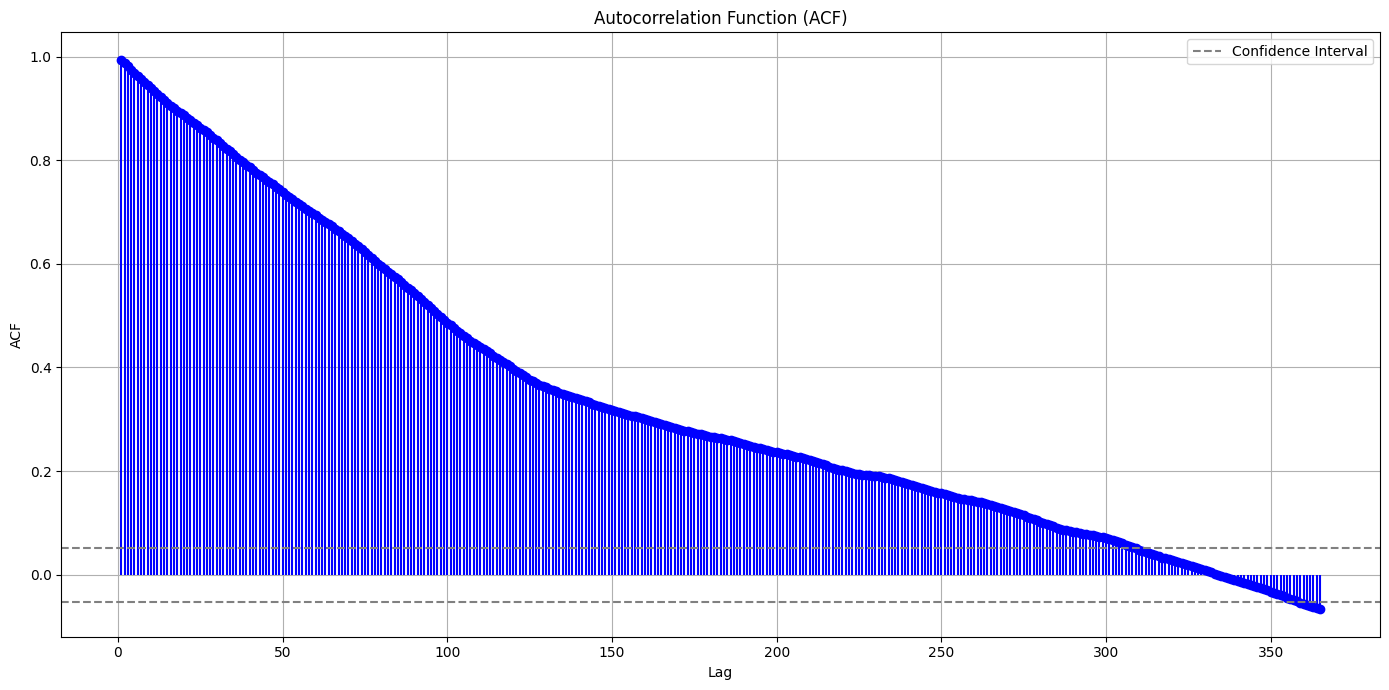

2024-10-01 17:29:49,565 - INFO - Initializing StocksClient...
2024-10-01 17:29:49,571 - INFO - Fetching aggregate bars data for 'SLV'...
2024-10-01 17:29:49,983 - INFO - HTTP Request: GET https://api.polygon.io/v2/aggs/ticker/SLV/range/1/day/2019-01-01/2024-09-01?adjusted=true&sort=asc&limit=500000 "HTTP/1.1 200 OK"
2024-10-01 17:29:50,024 - INFO - Converting response to DataFrame...
2024-10-01 17:29:50,029 - INFO - Creating daily date range...
2024-10-01 17:29:50,031 - INFO - Converting 'c' column to numeric...
2024-10-01 17:29:50,032 - INFO - Mean: 20.39, Standard Deviation: 3.79
2024-10-01 17:29:50,034 - INFO - No outliers detected.
2024-10-01 17:29:50,040 - INFO - SLV prices saved to 'SLV-Prices.csv'.
2024-10-01 17:29:50,042 - INFO - No significant seasonality detected.


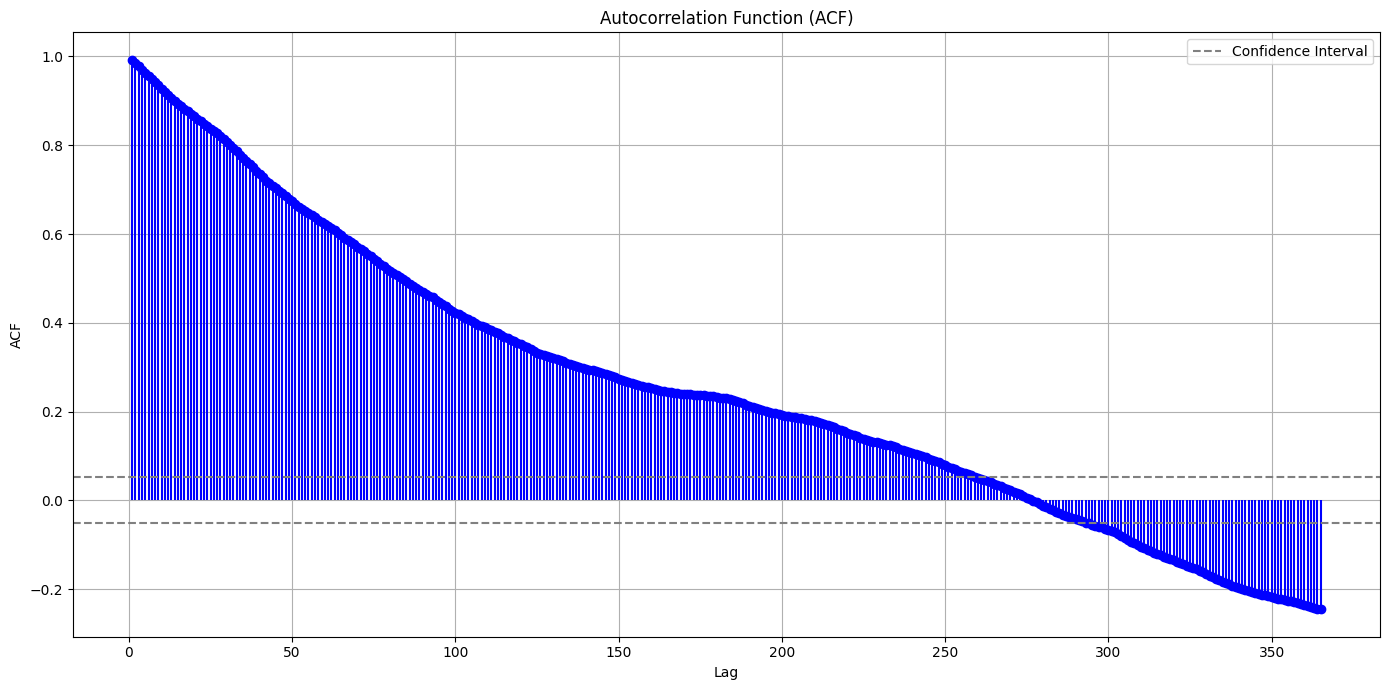

In [18]:
def find_optimal_seasonal_period(series, max_seasonal_period=365):
    """
    Determines the optimal seasonal period for a time series using autocorrelation analysis.
    Always plots the ACF and identified peaks for visual inspection.

    Parameters:
        series (pd.Series): The time series data.
        max_seasonal_period (int): The maximum seasonal period to consider.

    Returns:
        int or None: The suggested optimal seasonal period. Returns None if no seasonality is detected.
    """
    try:
        # Remove NaN values
        series = series.dropna()
        n = len(series)

        # Compute ACF up to max_seasonal_period
        lag_acf = acf(series, nlags=max_seasonal_period, fft=True)

        # Confidence interval for ACF
        conf_level = 1.96 / np.sqrt(n)

        # Find peaks in ACF that exceed the confidence interval
        peaks, properties = find_peaks(
            lag_acf[1:], height=conf_level)  # Exclude lag 0
        peaks = peaks + 1  # Adjust lag since ACF starts at lag 0

        if len(peaks) == 0:
            logging.info("No significant seasonality detected.")
            optimal_lag = None
        else:
            # Select the peak with the highest autocorrelation
            peak_heights = properties['peak_heights']
            optimal_lag = peaks[np.argmax(peak_heights)]
            logging.info(f"Optimal seasonal period detected: {optimal_lag}")

        # Plot the ACF with detected peaks
        plt.figure(figsize=(14, 7))
        plt.stem(range(1, max_seasonal_period + 1),
                 lag_acf[1:], linefmt='b-', markerfmt='bo', basefmt=' ')
        plt.axhline(y=conf_level, linestyle='--',
                    color='gray', label='Confidence Interval')
        plt.axhline(y=-conf_level, linestyle='--', color='gray')
        if len(peaks) > 0:
            plt.scatter(peaks, lag_acf[peaks],
                        color='red', label='Detected Peaks')
        plt.title('Autocorrelation Function (ACF)')
        plt.xlabel('Lag')
        plt.ylabel('ACF')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        return optimal_lag

    except Exception as e:
        logging.error(f"An error occurred in finding seasonal period: {e}")
        return None
    
gld_data = await get_GLD()
find_optimal_seasonal_period(gld_data)

slv_data = await get_SLV()
find_optimal_seasonal_period(slv_data)

# Analyzing ACF Plots with Straight Line Negative Slopes

When performing **Autocorrelation Function (ACF)** analysis to determine the optimal seasonal period in time series data, the shape and behavior of the ACF plot provide critical insights into the underlying patterns of the series. A common scenario to encounter is an ACF plot that exhibits a **straight line with a negative slope**. Understanding and interpreting this pattern is essential for accurate seasonality detection and subsequent modeling.

## **Understanding the Straight Line Negative Slope in ACF Plots**

### **1. What Does a Straight Line Negative Slope Indicate?**

A **straight line with a negative slope** in an ACF plot typically suggests the presence of a **trend** in the time series rather than seasonality. Here's why:

- **Trend Presence:**
  - **Consistent Decline:**  
    A negative slope indicates that as the lag increases, the autocorrelation decreases in a consistent manner. This pattern is characteristic of a **non-stationary series with a deterministic trend**.
  
  - **No Seasonal Peaks:**  
    Unlike seasonal patterns, which produce **significant peaks** at specific lags corresponding to the seasonal period, a straight declining line lacks these prominent spikes.

### **2. Implications for Seasonality Detection**

- **Absence of Seasonality:**
  - The lack of significant peaks in the ACF plot implies that there is **no strong seasonal component** in the data.
  
  - **Non-Seasonal Trend:**  
    The observed trend is **non-seasonal**, meaning that the series exhibits a consistent upward or downward movement over time without repeating cyclical patterns.

- **Modeling Considerations:**
  - **Seasonal Differencing May Be Unnecessary:**  
    Since the ACF plot does not indicate seasonality, applying seasonal differencing might not be beneficial and could potentially overcomplicate the model.
  
  - **Focus on Trend Differencing:**  
    Instead of seasonal differencing, consider applying **regular differencing** to remove the trend and achieve stationarity.

## **Step-by-Step Analysis Approach**

1. **Visual Inspection of the ACF Plot:**
   - **Identify Slope Pattern:**  
     Observe whether the ACF plot shows a straight declining line without significant peaks.
   
   - **Determine Significance:**  
     Assess if the autocorrelations lie within the confidence intervals. A consistently declining pattern outside these bounds reinforces the presence of a trend.

2. **Complementary Stationarity Tests:**
   - **Augmented Dickey-Fuller (ADF) Test:**  
     Confirms the presence of a unit root (non-stationarity) if the null hypothesis is not rejected.
   
   - **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:**  
     Checks for stationarity around a trend. A failure to reject the null hypothesis supports the presence of a trend.

3. **Apply Regular Differencing:**
   - **First-Order Differencing:**  
     Apply differencing to remove the trend component.
   
   - **Re-evaluate Stationarity:**  
     Perform stationarity tests again to ensure that the differenced series is now stationary.

4. **Re-analyze ACF Plot Post-Differencing:**
   - **Check for Remaining Patterns:**  
     After removing the trend, the ACF plot should ideally show no significant autocorrelations, indicating stationarity.


2024-10-01 17:29:50,187 - INFO - Initializing StocksClient...
2024-10-01 17:29:50,197 - INFO - Fetching aggregate bars data for 'SLV'...
2024-10-01 17:29:50,386 - INFO - HTTP Request: GET https://api.polygon.io/v2/aggs/ticker/GLD/range/1/day/2019-01-01/2024-09-01?adjusted=true&sort=asc&limit=500000 "HTTP/1.1 200 OK"
2024-10-01 17:29:50,449 - INFO - Converting response to DataFrame...
2024-10-01 17:29:50,453 - INFO - Creating daily date range...
2024-10-01 17:29:50,454 - INFO - Converting 'c' column to numeric...
2024-10-01 17:29:50,455 - INFO - Mean: 168.45, Standard Deviation: 23.65
2024-10-01 17:29:50,456 - INFO - No outliers detected.
2024-10-01 17:29:50,460 - INFO - GLD prices saved to 'GLD-Prices.csv'.
2024-10-01 17:29:50,460 - INFO - Initializing StocksClient...
2024-10-01 17:29:50,468 - INFO - Fetching aggregate bars data for 'SLV'...
2024-10-01 17:29:50,630 - INFO - HTTP Request: GET https://api.polygon.io/v2/aggs/ticker/SLV/range/1/day/2019-01-01/2024-09-01?adjusted=true&sort=

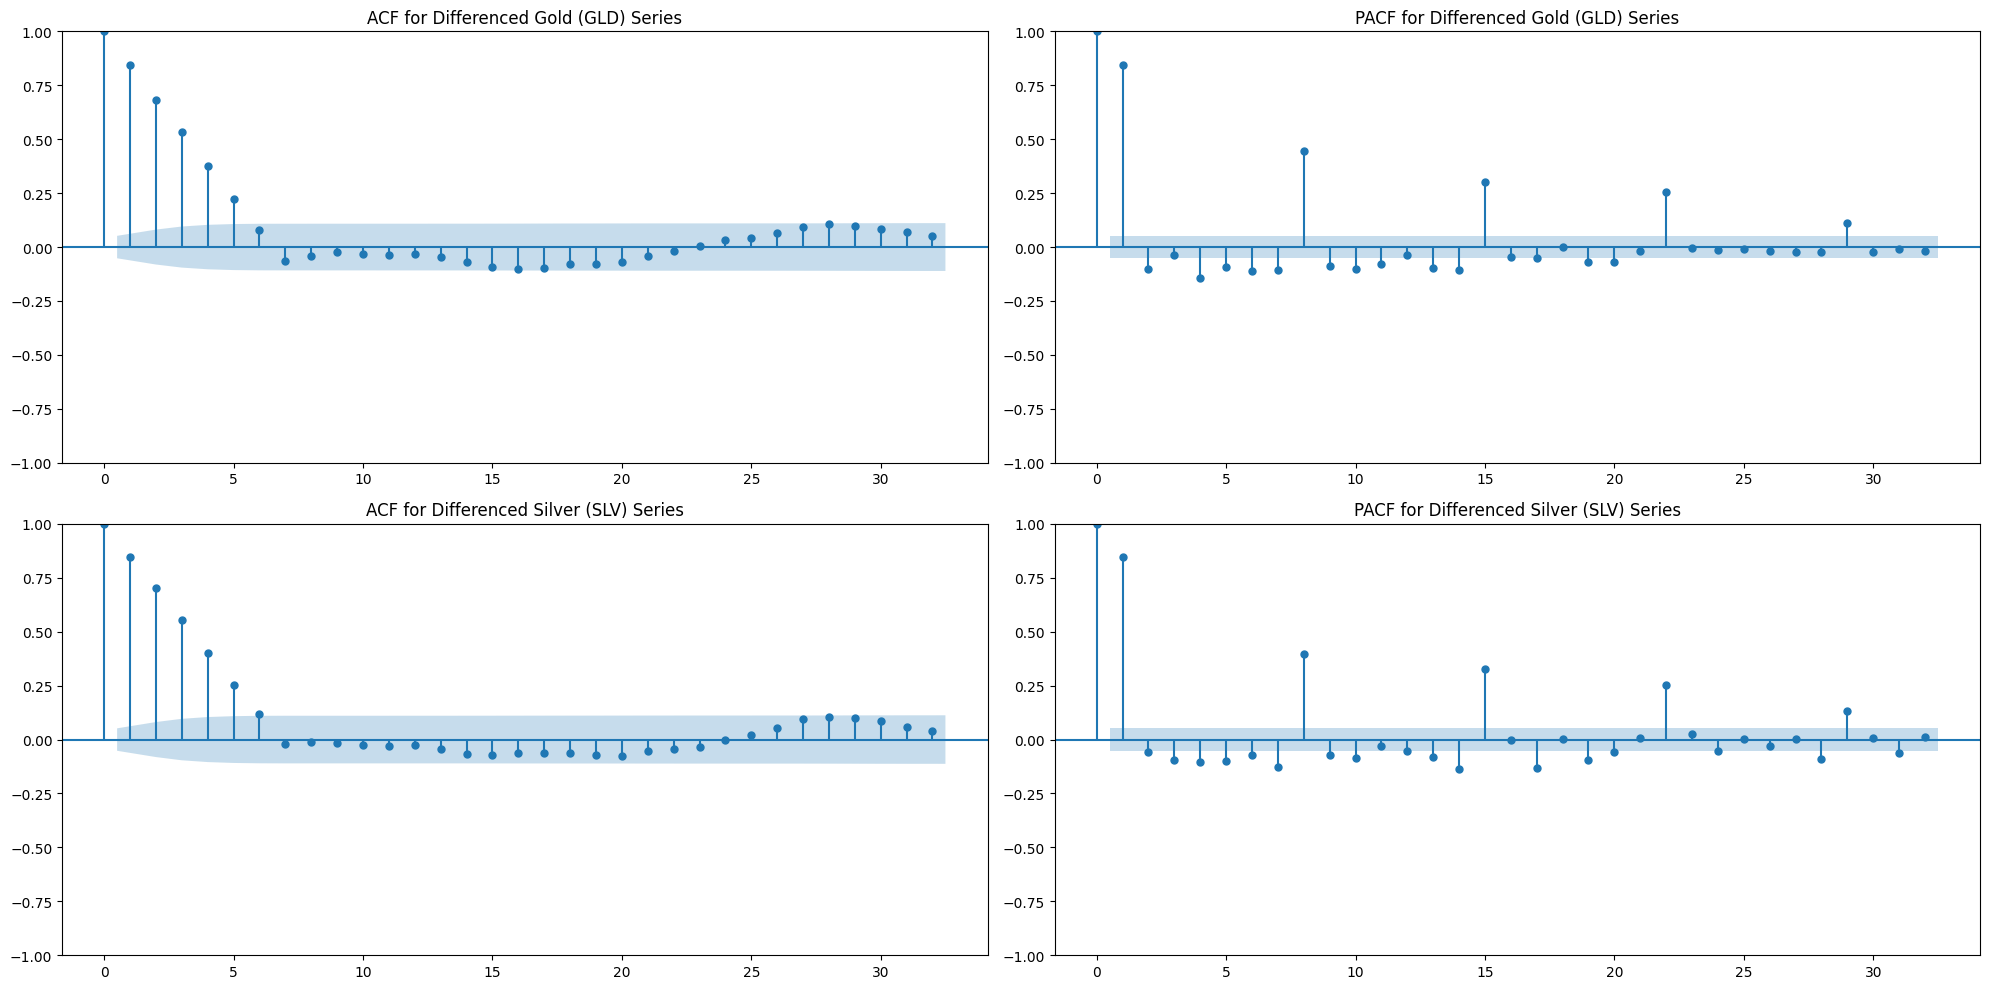

In [19]:
gld_data = await get_GLD()
slv_data = await get_SLV()

if gld_data is None or slv_data is None:
    logging.error("Data fetching failed. Exiting the plotting function.")

seasonal_period = 7  # For weekly seasonality in daily data

# Create a figure with 2 rows and 2 columns of subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# ACF and PACF for Gold (GLD)
plot_acf(gld_data['c'].diff(seasonal_period).dropna(), ax=axes[0, 0])
axes[0, 0].set_title("ACF for Differenced Gold (GLD) Series")
plot_pacf(gld_data['c'].diff(seasonal_period).dropna(), ax=axes[0, 1])
axes[0, 1].set_title("PACF for Differenced Gold (GLD) Series")

# ACF and PACF for Silver (SLV)
plot_acf(slv_data['c'].diff(seasonal_period).dropna(), ax=axes[1, 0])
axes[1, 0].set_title("ACF for Differenced Silver (SLV) Series")
plot_pacf(slv_data['c'].diff(seasonal_period).dropna(), ax=axes[1, 1])
axes[1, 1].set_title("PACF for Differenced Silver (SLV) Series")

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

# Autocorrelation and Partial Autocorrelation Analysis for Gold (GLD) and Silver (SLV)

In this section, we analyze the **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** plots for the **Gold (GLD)** and **Silver (SLV)** time series data. These analyses help us uncover underlying patterns and dependencies, which are essential for building effective forecasting models.


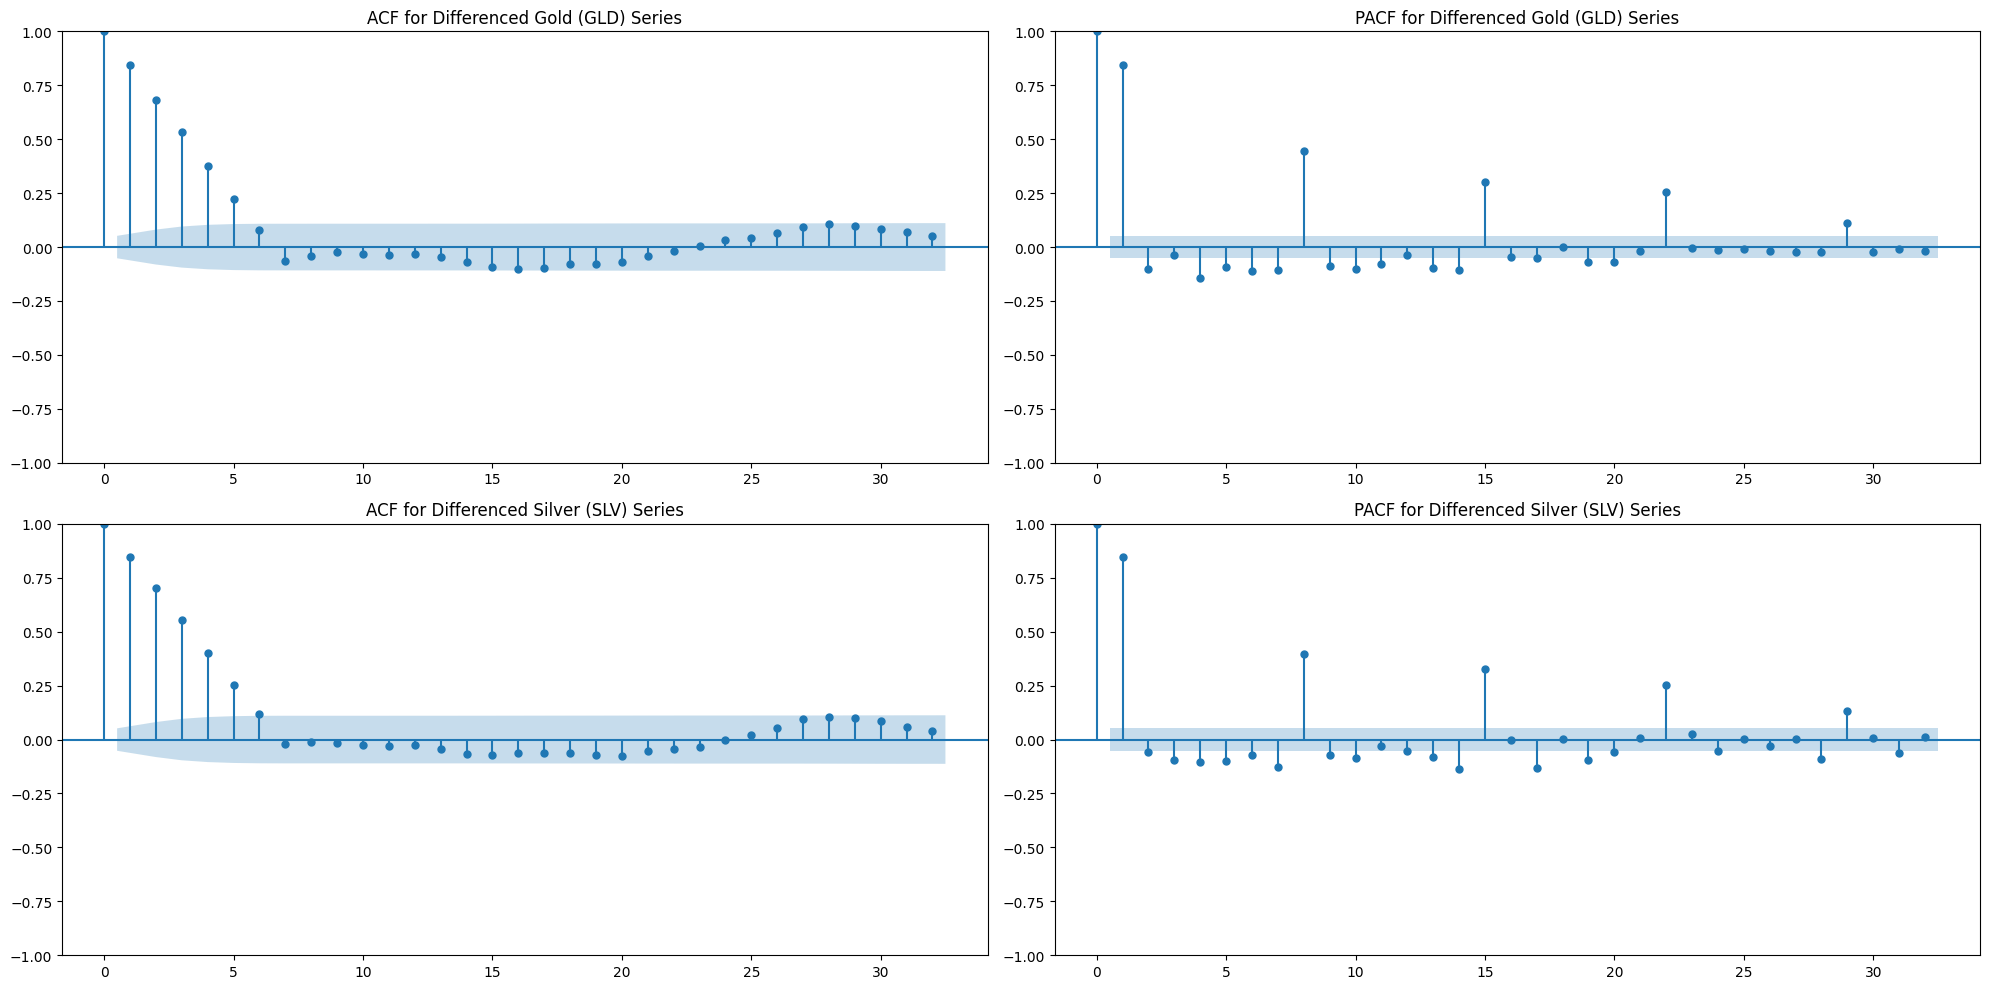

In [20]:
def plot_acf_pacf(series, seasonal_period, title_prefix, axes):
    """
    Plots ACF and PACF for a given time series after seasonal differencing.

    Parameters:
        series (pd.Series): The time series data.
        seasonal_period (int): The number of periods in a season.
        title_prefix (str): Prefix for the plot titles (e.g., 'Gold (GLD)').
        axes (array): Array of matplotlib axes to plot on.
    """
    differenced = series.diff(seasonal_period).dropna()

    plot_acf(differenced, ax=axes[0])
    axes[0].set_title(f"ACF for Differenced {title_prefix} Series")

    plot_pacf(differenced, ax=axes[1])
    axes[1].set_title(f"PACF for Differenced {title_prefix} Series")


# Create a 2x2 grid for Gold and Silver
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# Plot for Gold
plot_acf_pacf(gld_data['c'], seasonal_period, "Gold (GLD)", axes[0])

# Plot for Silver
plot_acf_pacf(slv_data['c'], seasonal_period, "Silver (SLV)", axes[1])

plt.tight_layout()
plt.show()

# Seasonal Decomposition of Gold (GLD) and Silver (SLV) Time Series

In this section, we perform **seasonal decomposition** on the time series data for **Gold (GLD)** and **Silver (SLV)**. Seasonal decomposition breaks down a time series into its fundamental components, allowing for a clearer understanding of underlying patterns and trends. This process is essential for building accurate forecasting models.

## **Purpose of Seasonal Decomposition**

Seasonal decomposition separates a time series into three main components:

1. **Trend:** The long-term progression or movement in the data.
2. **Seasonality:** Regular, repeating patterns or cycles within the data.
3. **Residuals:** Random noise or irregular fluctuations remaining after removing trend and seasonality.

By isolating these components, we can analyze each aspect individually, enhancing our ability to model and forecast future values effectively.

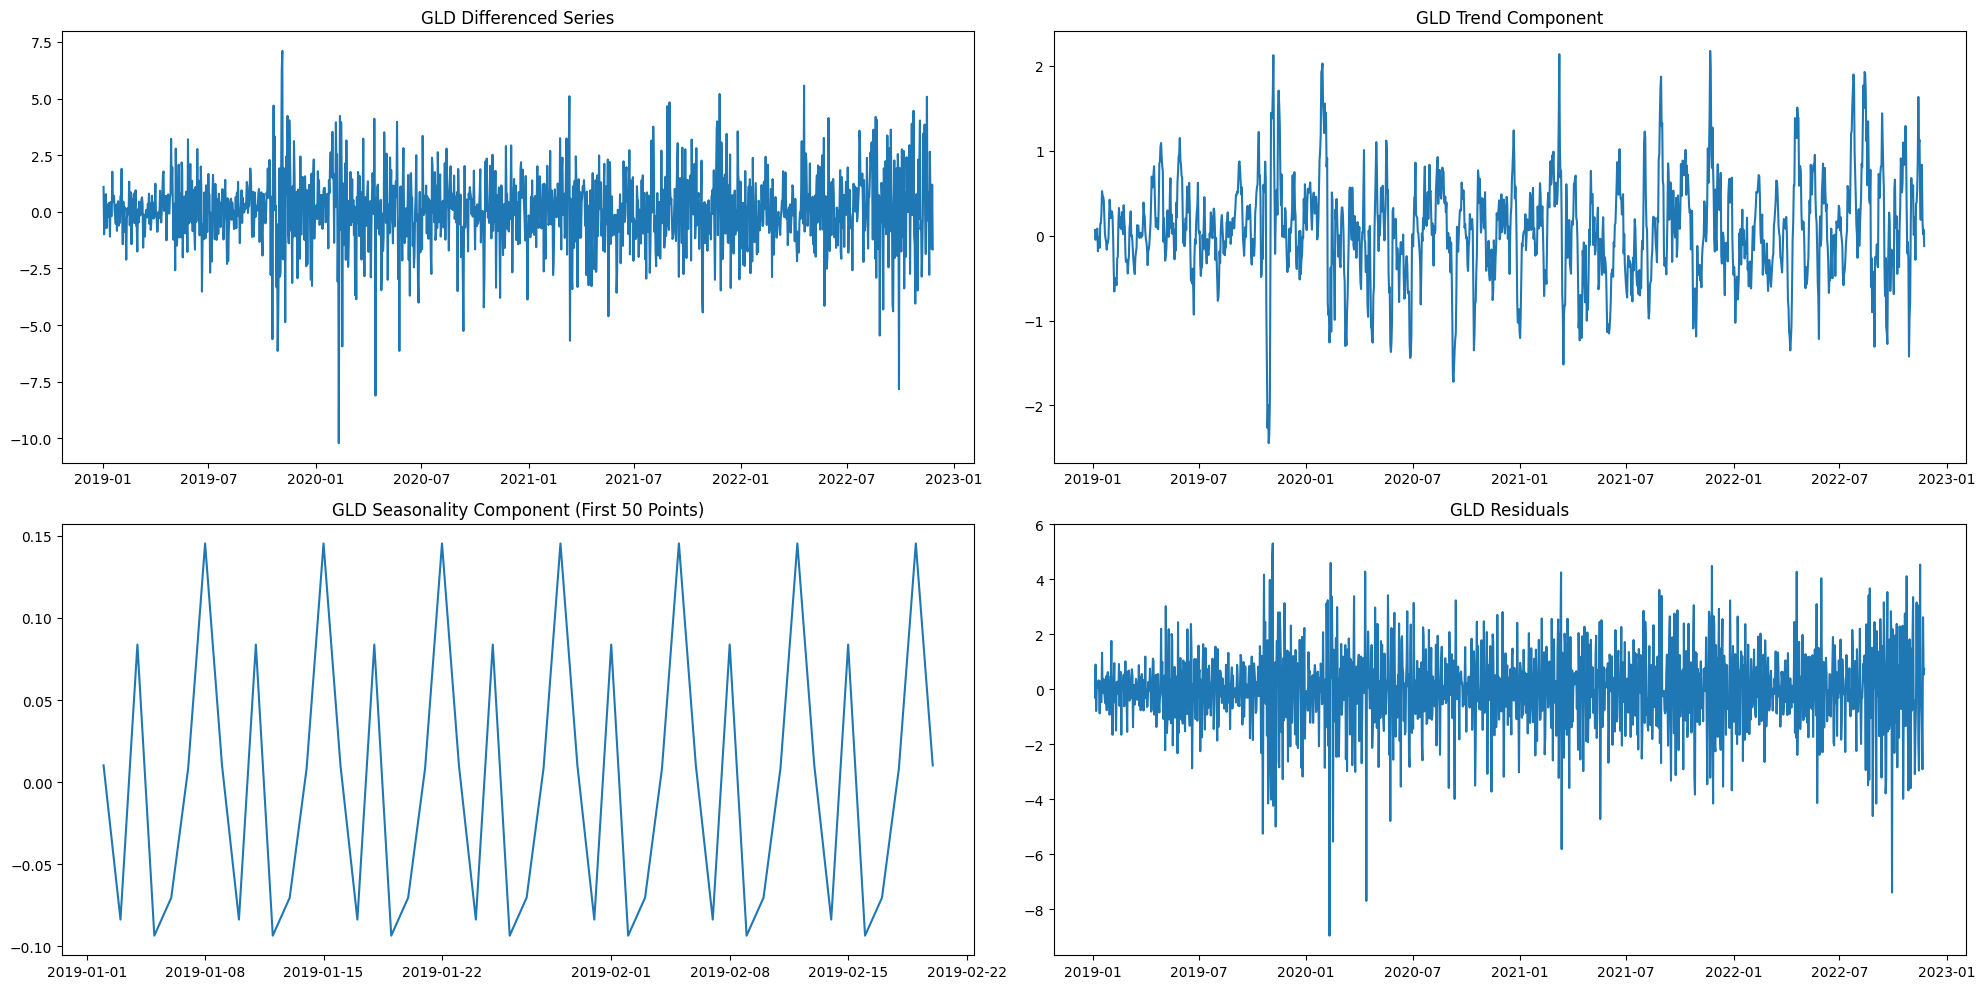

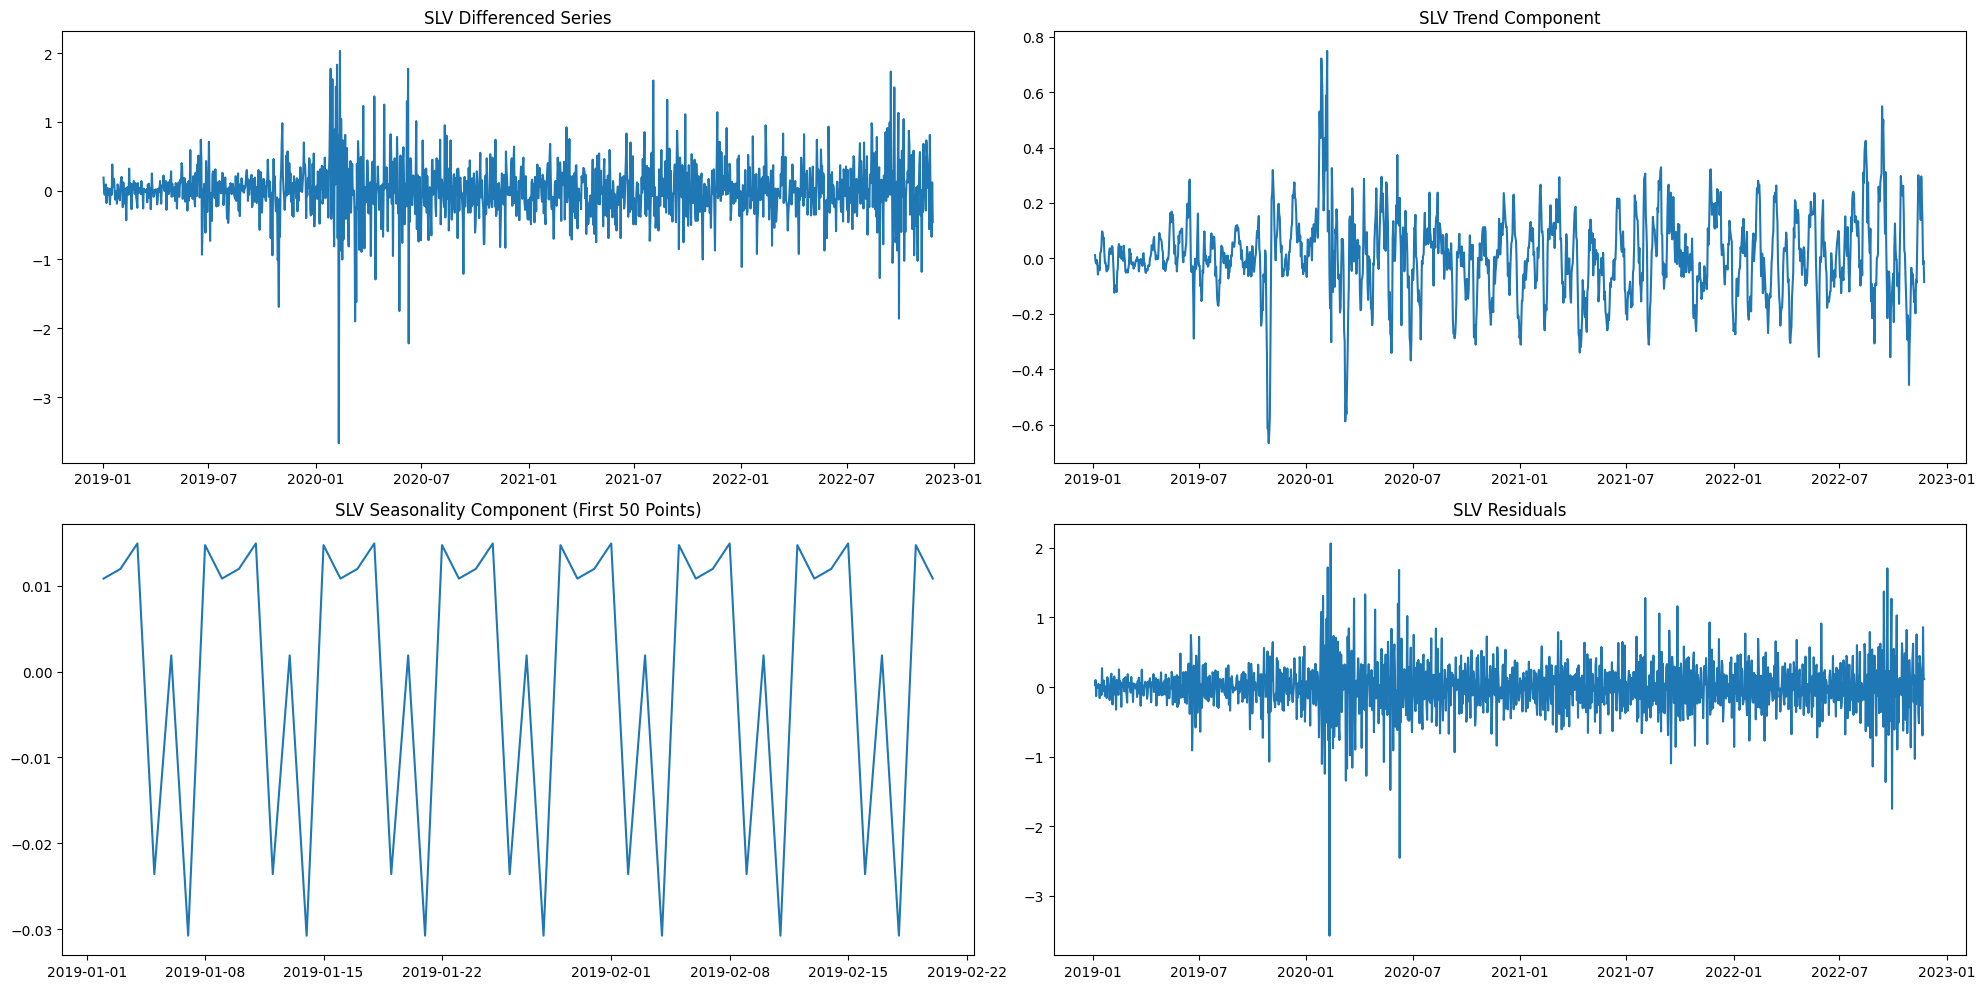

In [21]:
def plot_seasonal_decomposition(ts, ticker, seasonal_period=7):
    decomposition = seasonal_decompose(ts.diff().dropna(), model='additive')

    trend = decomposition.trend
    seasonality = decomposition.seasonal
    resid = decomposition.resid

    fig = plt.figure(figsize=(20, 10))

    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)

    ax1.plot(ts.diff().dropna())
    ax1.set_title(f"{ticker} Differenced Series")

    ax2.plot(trend)
    ax2.set_title(f"{ticker} Trend Component")

    ax3.plot(seasonality[:50])
    ax3.set_title(f"{ticker} Seasonality Component (First 50 Points)")

    ax4.plot(resid)
    ax4.set_title(f"{ticker} Residuals")

    plt.tight_layout()
    plt.show()
    return trend, seasonality, resid


# Assuming 'gld_data' and 'slv_data' are fetched and contain a 'c' column for close prices
trend_gld, seasonality_gld, resid_gld = plot_seasonal_decomposition(gld_data['c'], 'GLD')
trend_slv, seasonality_slv, resid_slv = plot_seasonal_decomposition(
    slv_data['c'], 'SLV')

# Autocorrelation and Partial Autocorrelation Analysis for Trend and Seasonality Components

In this section, we analyze the **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** for the **trend** and **seasonality** components of the **Gold (GLD)** and **Silver (SLV)** time series. Understanding these plots helps us identify patterns and dependencies, which are crucial for building accurate forecasting models.

## **1. Purpose of ACF and PACF Analysis**

- **Autocorrelation Function (ACF):**  
  Measures the correlation between the time series and its lagged values. It helps identify repeating patterns or cycles in the data.

- **Partial Autocorrelation Function (PACF):**  
  Measures the correlation between the time series and its lagged values while controlling for the correlations at shorter lags. It helps determine the direct relationships between observations.

## **2. Decomposed Components**

Before analyzing ACF and PACF, we decompose the time series into its fundamental components:

1. **Trend:**  
   The long-term movement or direction in the data (e.g., increasing or decreasing prices).

2. **Seasonality:**  
   Regular, repeating patterns or cycles within the data (e.g., weekly or monthly fluctuations).

3. **Residuals:**  
   Random noise or irregular fluctuations remaining after removing trend and seasonality.

## **3. Plotting ACF and PACF for Each Component**

The provided function `plot_acf_pacf_for_series` creates ACF and PACF plots for both the trend and seasonality components of GLD and SLV. Here's how it works conceptually:

### **a. Gold (GLD) Analysis**

- **Trend Component:**
  - **ACF Plot:**  
    Shows how the trend is correlated with its past values. Look for significant autocorrelations at various lags, which indicate persistent trends.
  
  - **PACF Plot:**  
    Highlights the direct influence of past trend values on the current trend. Significant spikes suggest the order of autoregressive terms needed in modeling.

- **Seasonality Component:**
  - **ACF Plot:**  
    Reveals repeating seasonal patterns by showing correlations at seasonal lags (e.g., every 7 days for weekly seasonality).
  
  - **PACF Plot:**  
    Identifies the direct seasonal dependencies, helping to determine the appropriate seasonal AR terms in the model.

### **b. Silver (SLV) Analysis**

- **Trend Component:**
  - **ACF Plot:**  
    Similar to GLD, it displays how the trend in SLV is related to its past values. Significant lags indicate strong trend persistence.
  
  - **PACF Plot:**  
    Shows the direct impact of past trend values on the current trend, aiding in selecting AR terms.

- **Seasonality Component:**
  - **ACF Plot:**  
    Detects regular seasonal patterns by highlighting significant correlations at seasonal lags.
  
  - **PACF Plot:**  
    Helps in pinpointing the direct seasonal effects, guiding the inclusion of seasonal AR terms in the model.

## **4. What to Look For in the ACF and PACF Plots**

- **Significant Peaks:**
  - **Above Confidence Intervals:**  
    Spikes that exceed the confidence bounds indicate significant autocorrelations at those lags.
  
  - **Pattern Recognition:**  
    Regularly spaced peaks at seasonal lags confirm the presence of seasonality.

- **Decay Patterns:**
  - **Gradual Decay in ACF:**  
    Suggests a persistent trend in the data.
  
  - **Sharp Cutoffs in PACF:**  
    Help determine the number of AR terms needed in the model.

- **Seasonal Lags:**
  - **Recurring Spikes:**  
    For example, spikes at lag 7 in daily data indicate weekly seasonality.




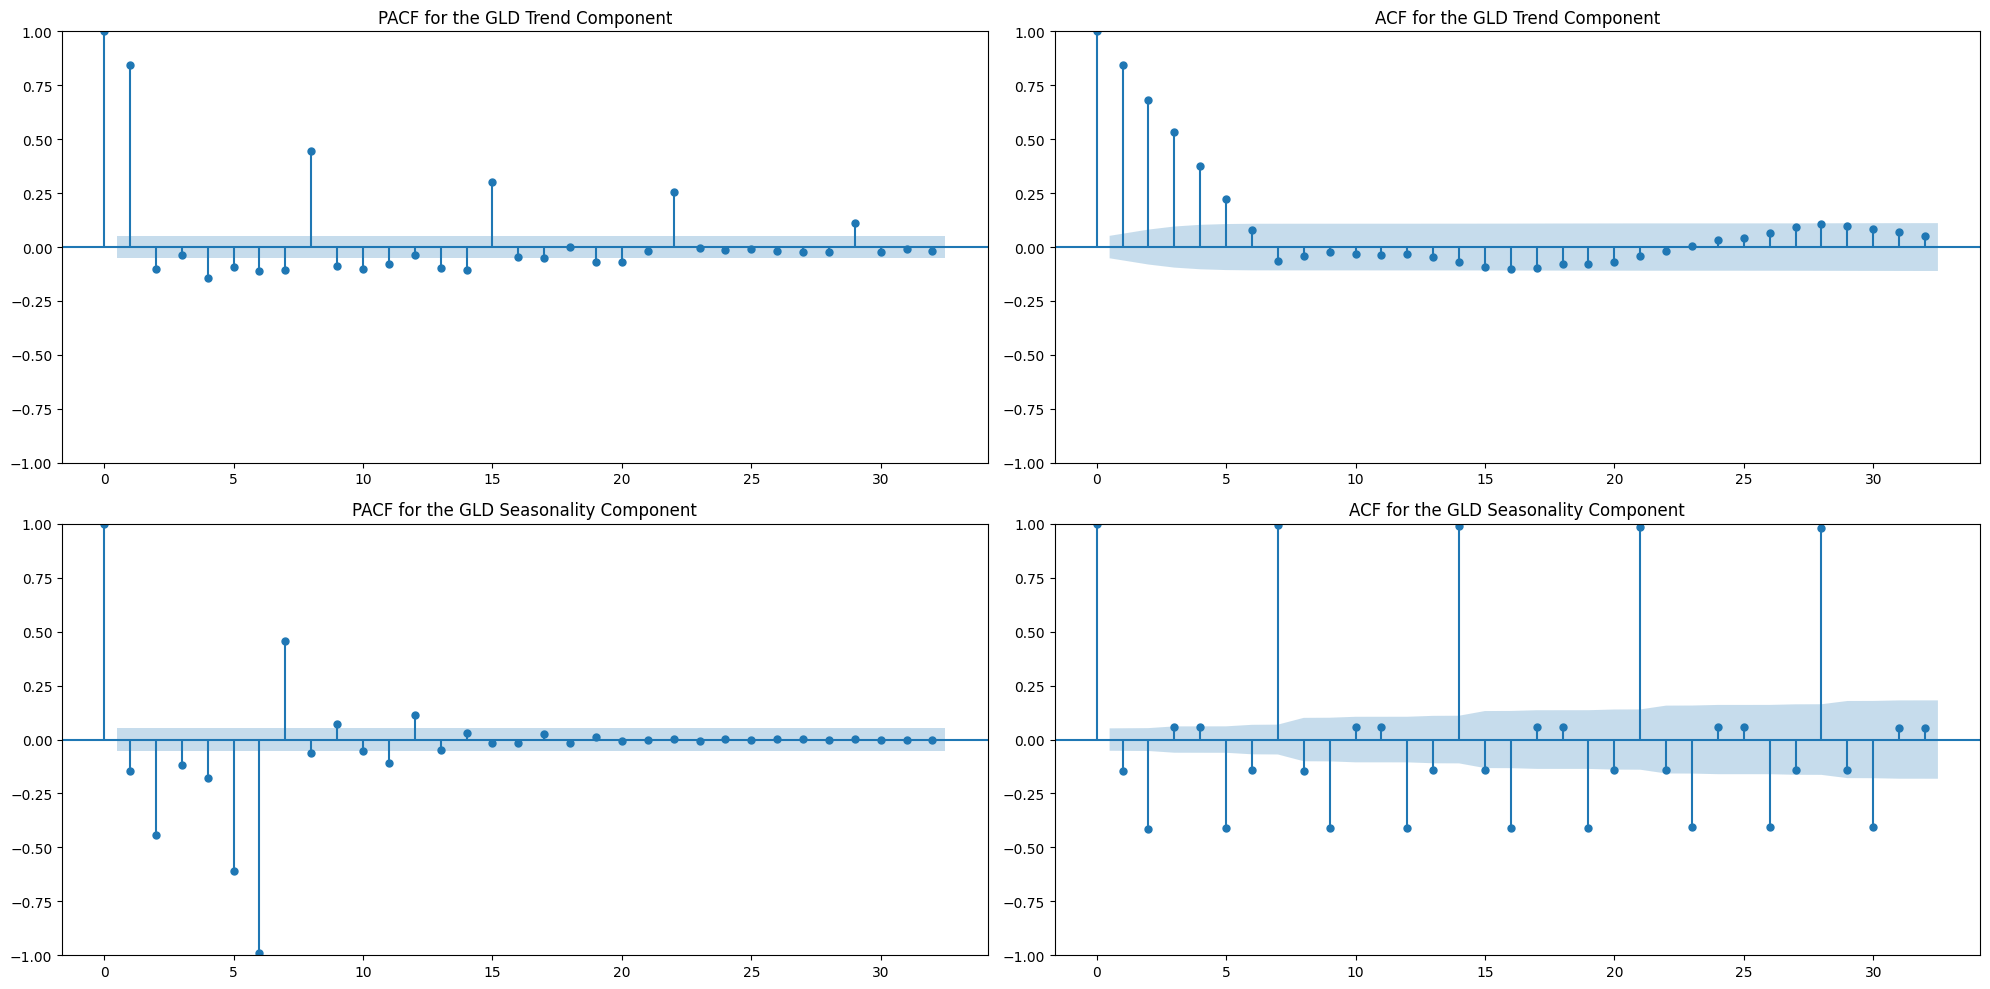

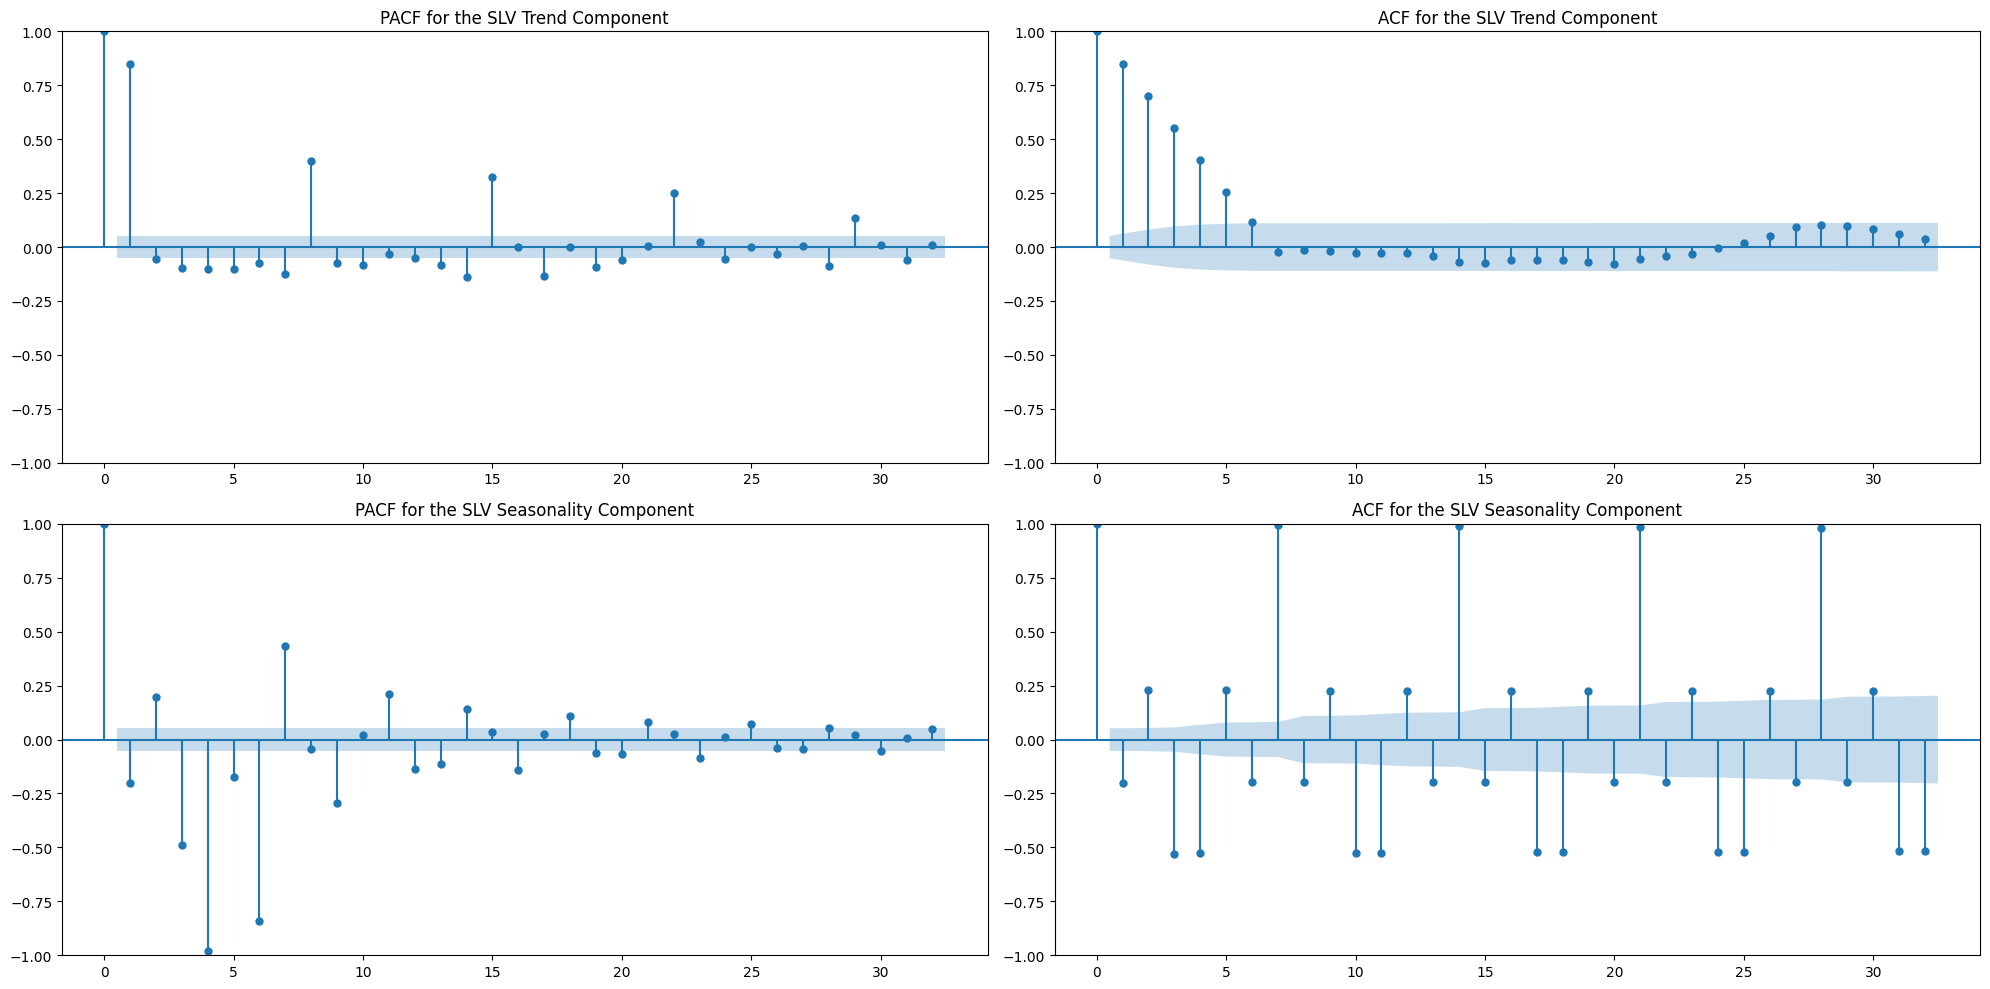

In [22]:
def plot_acf_pacf_for_series(trend_gld, seasonality_gld, trend_slv, seasonality_slv):
    """
    Plots ACF and PACF for the trend and seasonality components of Gold (GLD) and Silver (SLV) time series.

    Parameters:
        trend_gld (pd.Series): Trend component of GLD.
        seasonality_gld (pd.Series): Seasonality component of GLD.
        trend_slv (pd.Series): Trend component of SLV.
        seasonality_slv (pd.Series): Seasonality component of SLV.
    """
    try:
        # Create a figure for Gold (GLD)
        fig_gld = plt.figure(figsize=(20, 10))

        # PACF for GLD Trend
        ax1 = fig_gld.add_subplot(2, 2, 1)
        plot_pacf(trend_gld.dropna(), ax=ax1)
        ax1.set_title("PACF for the GLD Trend Component")

        # ACF for GLD Trend
        ax2 = fig_gld.add_subplot(2, 2, 2)
        plot_acf(trend_gld.dropna(), ax=ax2)
        ax2.set_title("ACF for the GLD Trend Component")

        # PACF for GLD Seasonality
        ax3 = fig_gld.add_subplot(2, 2, 3)
        plot_pacf(seasonality_gld, ax=ax3)
        ax3.set_title("PACF for the GLD Seasonality Component")

        # ACF for GLD Seasonality
        ax4 = fig_gld.add_subplot(2, 2, 4)
        plot_acf(seasonality_gld, ax=ax4)
        ax4.set_title("ACF for the GLD Seasonality Component")

        plt.tight_layout()
        plt.show()

        # Create a figure for Silver (SLV)
        fig_slv = plt.figure(figsize=(20, 10))

        # PACF for SLV Trend
        ax5 = fig_slv.add_subplot(2, 2, 1)
        plot_pacf(trend_slv.dropna(), ax=ax5)
        ax5.set_title("PACF for the SLV Trend Component")

        # ACF for SLV Trend
        ax6 = fig_slv.add_subplot(2, 2, 2)
        plot_acf(trend_slv.dropna(), ax=ax6)
        ax6.set_title("ACF for the SLV Trend Component")

        # PACF for SLV Seasonality
        ax7 = fig_slv.add_subplot(2, 2, 3)
        plot_pacf(seasonality_slv, ax=ax7)
        ax7.set_title("PACF for the SLV Seasonality Component")

        # ACF for SLV Seasonality
        ax8 = fig_slv.add_subplot(2, 2, 4)
        plot_acf(seasonality_slv, ax=ax8)
        ax8.set_title("ACF for the SLV Seasonality Component")

        plt.tight_layout()
        plt.show()

    except Exception as e:
        logging.error(f"An error occurred while plotting ACF and PACF: {e}")


# Now, plot ACF and PACF for both
plot_acf_pacf_for_series(trend_gld, seasonality_gld,
                         trend_slv, seasonality_slv)

In [23]:

# For GLD
auto_model_gld = auto_arima(
    gld_data, seasonal=False, stepwise=True, suppress_warnings=True)
optimal_d_gld = auto_model_gld.order[1]

NameError: name 'auto_arima' is not defined